# DEEP LEARNING - TIME SERIES
## Autor: Jesús Berríos <br>
<br>

---
#### 0.- INTRODUCCIÓN
#### 1.- CARGA DE DATOS
#### 2.- BREVE DESCRIPCIÓN DE LOS DATOS
#### 3.- CURACIÓN Y PREPARACIÓN DE LOS DATOS
#### 4.- PROPUESTA PARA ABORDAR EL PROBLEMA
#### 5.- CONSTRUCCIÓN, FIT Y EVALUACIÓN DE LAS ARQUITECTURAS DE DEEP LEARNING
#### 6.- SUMARIZACIÓN Y ANÁLISIS DE RESULTADOS
#### 7.- CONCLUSIONES FINALES

---
Se importan las librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import losses, metrics
from sklearn.metrics import mean_squared_error
from tensorflow.random import set_seed
from numpy.random import seed

---
## 0.- INTRODUCCIÓN
Se desea desarrollar un modelo de predicción de series de tiempo para indicadores de criptomonedas, específicamente **predecir el valor de apertura (Open) diario del Bitcoin.**

## SET DE DATOS
Se contará con el dataset de la series de tiempo del Bitcoin. El cual posee el valor de apertura, mínimo, máximo, cierre y volumen (cantidad de transacciones). 


## PLAN DE ACCIÓN
Para predecir el valor *Open* del bitcoin se ejecutará el siguiente plan de acción:
* Se dividirá el conjunto **train/test**:
    * Test: Datos de los últimos 30 días
    * Train: Datos desde el inicio de la serie temporal hasta donde comienza el set de test
<br><br>
* Definir una **ventana de tiempo de 60 timesteps y una salida**, de forma que el valor a predecir dependa del valor del Bitcoin u otras variables de 60 días atrás.
<br><br>
* Probar distintas **estructuras de variables dependientes**:
    * Utilizar sólo el valor de apertura de la acción del Bitcoin
        * A esta estructura se le agregará una prueba de concepto. La cual consistirá en predecir la ventana de 30 días sólo dependiendo del primer valor predicho, es decir, sin actualizar los valores de predicción mientras transcurre la línea de tiempo. 
    * Utilizar valores de apertura, cierre, mínimo, máximo y volumen como variables dependientes.
<br><br>
* **Valor a predecir**: El valor después del último día del set de train, que correspondería al primer valor del set de test, se predecirá a partir de los últimos 60 días del set de train. Luego, para predecir el segundo día del set de test, el valor ***real*** del set de test se agregará a la pila de valores de X_test, el cual se rotará una unidad de tiempo (día), descartando el valor más antiguo. Con este procedimiento se procedrá a hacer la estimación de los siguientes 30 días para las estructuras de variables y arquitecturas propuestas. Es relevante destacar que en **términos prácticos el método sólo predice el valor del día siguiente**, pero se le agregan valores reales para ver **cómo se comportaría ante los cambios de la tendencia y así apreciar la robustez de las configuraciones**. A continuación se presenta un **diagrama** en el que se puede apreciar la evolución temporal del set X_test (sobre el cual se predice), el valor real y los valores predichos, para poder así obtener los valores predichos de los siguientes 30 días:
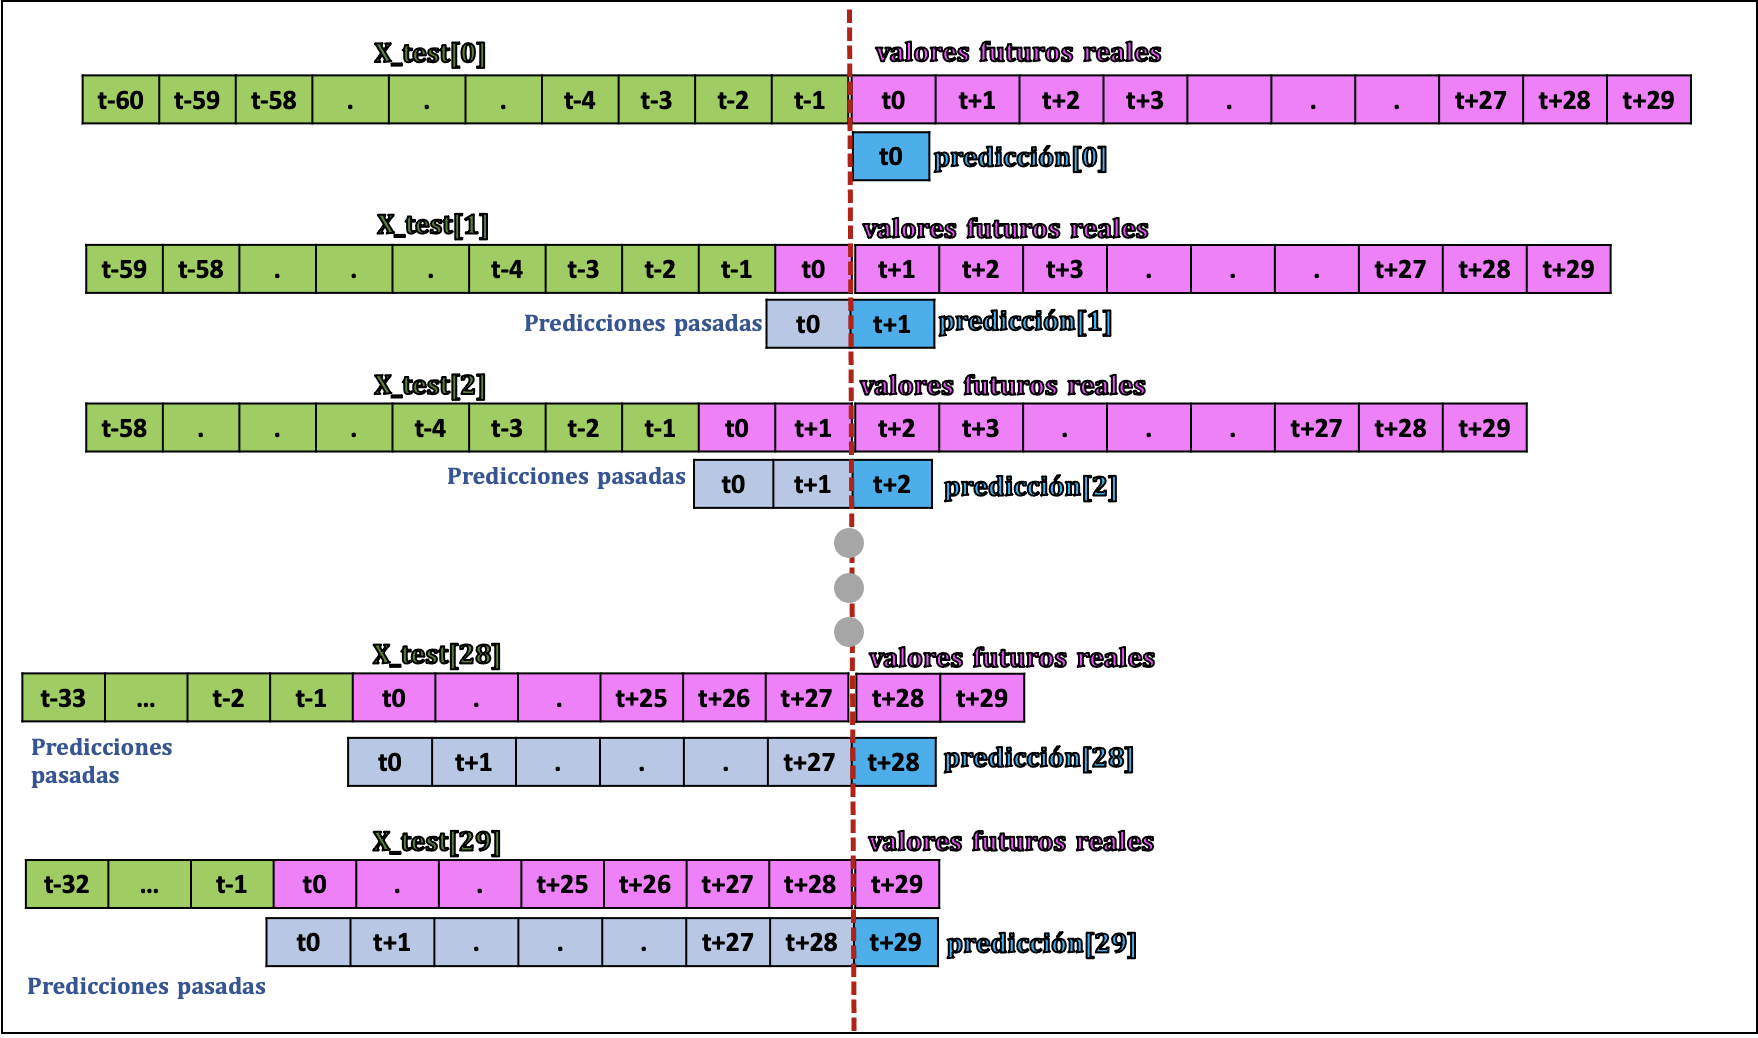
<br><br>
    
    
* **Prueba de concepto:** A continuación se presenta un **diagrama con la prueba de concepto** planteada para la estructura 1, para lo que se irá agregando a la pila X_test los valores predichos, de modo que la predicción sea independiente de los valores reales durante los próximos 30 días y no tenga sólo el alcance de predecir el siguiente día:
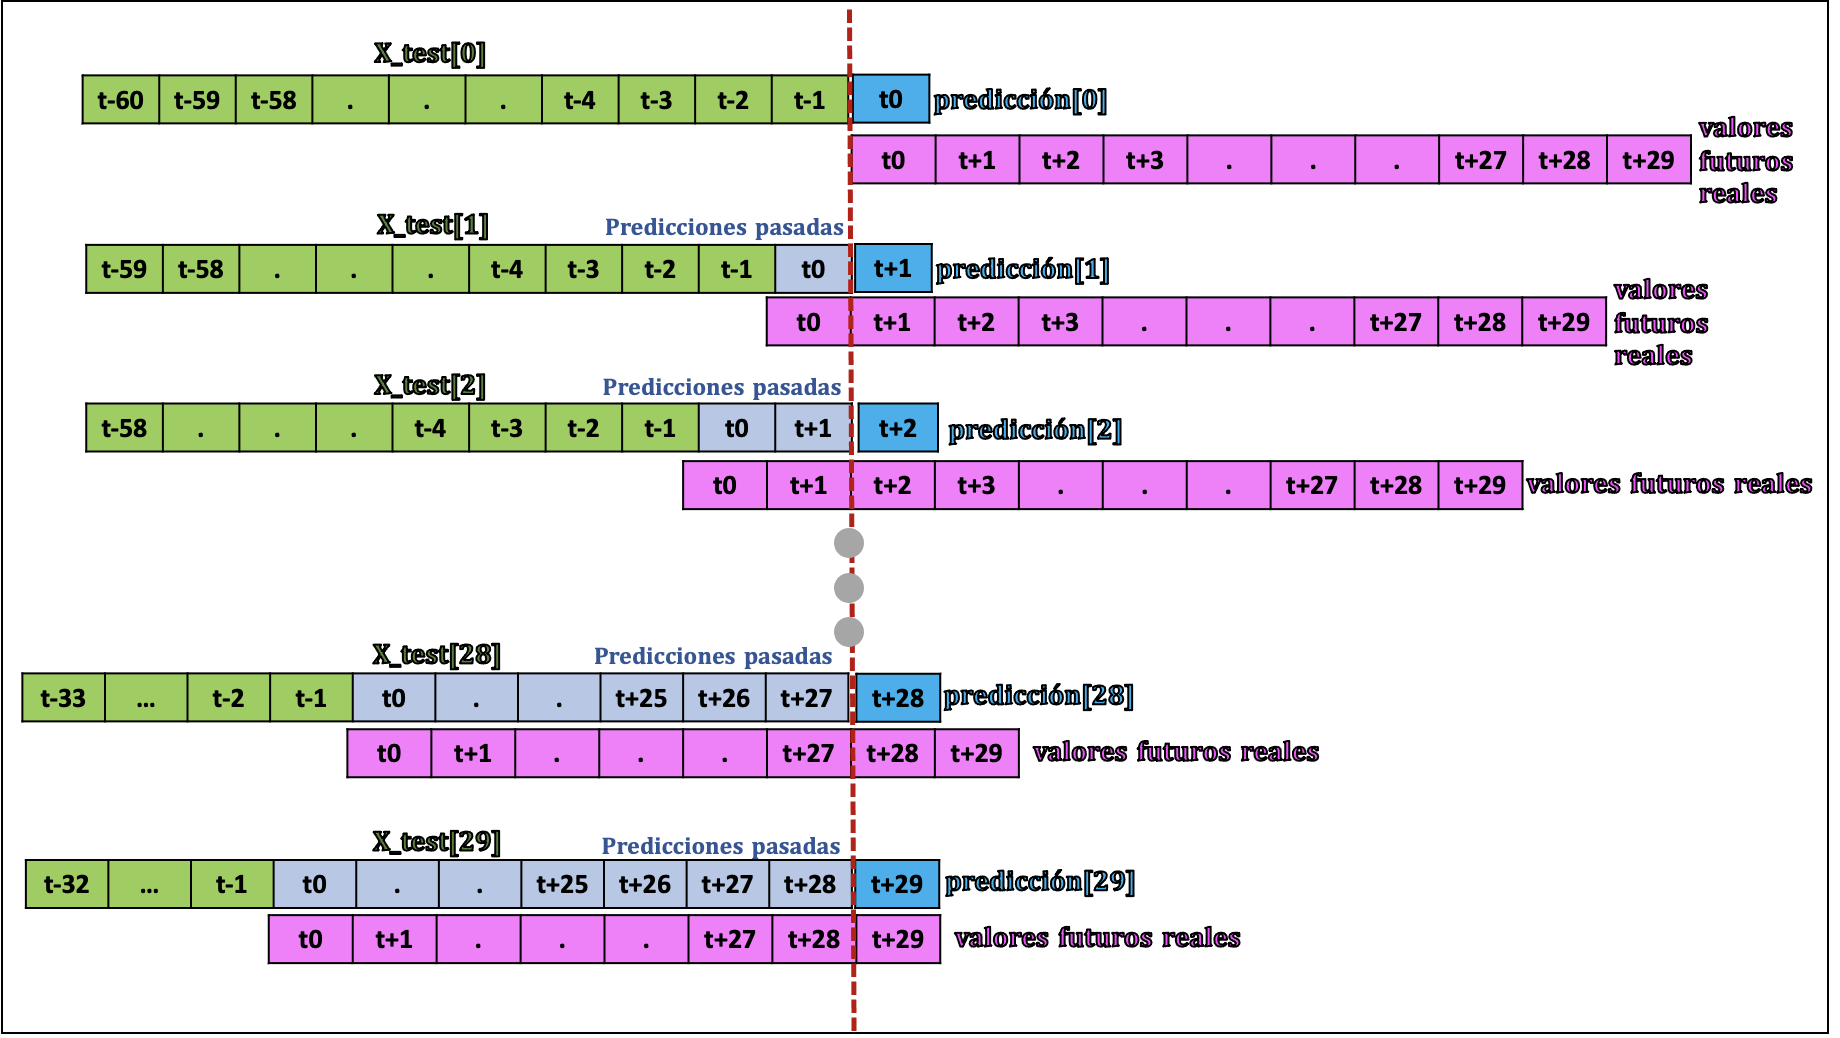
<br><br> 
    
    
* Construir distintas **arquitecturas de Deep Learning**: 
    * Red Neuronal Densa
    * Red Neuronal Recurrente con una capa LSTM + Capa de Salida
    * Red Neuronal Recurrente varias capas LSTM + Capa de Salida
<br><br>  

***DISCLAIMER: La prueba de concepto fue ejecutada sólo con el objetivo de descubrir qué pasaría si el método es aplicado de la forma planteada, con la finalidad de aclarar dudas personales y así poder tener un mayor entendimiento de cómo funcionan las predicciones. La misma no fue basada en algún basamento teórico, por lo que tal cual como se describe, es una prueba.***

---
## 1.- CARGA DE DATOS
Se importan los datos de Bitcoin

In [2]:
dfb = pd.read_csv('./BTC-USD.csv').dropna().drop(['Adj Close'],axis=1).reset_index(drop=True)
dfb

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07
...,...,...,...,...,...,...
2587,2021-10-21,66002.234375,66600.546875,62117.410156,62210.171875,4.590812e+10
2588,2021-10-22,62237.890625,63715.023438,60122.796875,60692.265625,3.843408e+10
2589,2021-10-23,60694.628906,61743.878906,59826.523438,61393.617188,2.688255e+10
2590,2021-10-24,61368.343750,61505.804688,59643.343750,60930.835938,2.731618e+10


---
## 2.- BREVE DESCRIPCIÓN DE LOS DATOS

In [3]:
(dfb == dfb.drop_duplicates()).groupby(list(dfb.columns)).last()

,,,,,
Date,Open,High,Low,Close,Volume
True,True,True,True,True,True


In [4]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2592 non-null   object 
 1   Open    2592 non-null   float64
 2   High    2592 non-null   float64
 3   Low     2592 non-null   float64
 4   Close   2592 non-null   float64
 5   Volume  2592 non-null   float64
dtypes: float64(5), object(1)
memory usage: 121.6+ KB


* No existen datos duplicados
* Las columnas que contienen los valores del eje vertical en la serie de tiempo son: **High, Low, Open, Close y Volume**. Todos son float
* La columna que contiene los valores de fecha en la serie temporal es *Date*, el cual será transformado a un formato de fecha conveniente para su fácil manejo.

Se adapta columna *Date*:

In [5]:
dfb.Date = dfb.Date.apply(lambda x: datetime.strptime(x.split(' ')[0],'%Y-%m-%d'))
dfb

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07
...,...,...,...,...,...,...
2587,2021-10-21,66002.234375,66600.546875,62117.410156,62210.171875,4.590812e+10
2588,2021-10-22,62237.890625,63715.023438,60122.796875,60692.265625,3.843408e+10
2589,2021-10-23,60694.628906,61743.878906,59826.523438,61393.617188,2.688255e+10
2590,2021-10-24,61368.343750,61505.804688,59643.343750,60930.835938,2.731618e+10


### **Medidas estadísticas de los valores de los distintos features**

In [6]:
dfb.describe()

,Open,High,Low,Close,Volume
count,2592.000000,2592.000000,2592.000000,2592.000000,2.592000e+03
mean,9583.487450,9855.981315,9293.152250,9606.834919,1.380550e+10
std,14098.986490,14522.373096,13638.021970,14135.993676,1.990124e+10
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,578.151001,583.402267,573.597779,578.156997,7.425972e+07
50%,5572.292969,5749.340088,5396.048584,5573.956055,4.604505e+09
75%,9726.268067,9937.428223,9533.110596,9730.781738,2.245061e+10
max,66002.234375,66930.390625,63610.675781,65992.835938,3.509679e+11


### **Diagramas de caja**

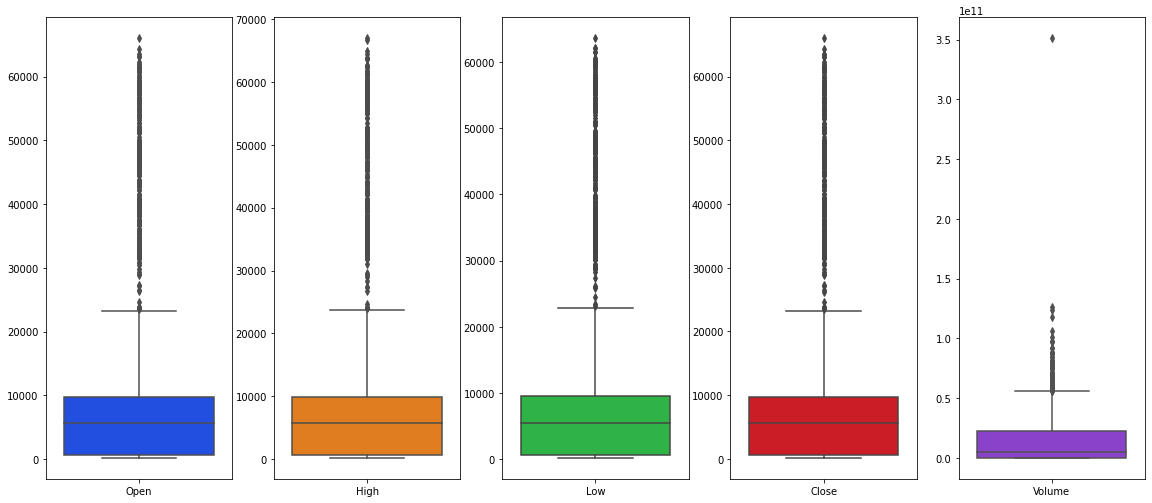

In [7]:
fig, axes = plt.subplots(1,5,figsize=(16,7))
fig.tight_layout()
axes = axes.flatten()

for i,j in enumerate(dfb.columns[1:]):
    ax = axes[i]
    ax = sns.boxplot(data = dfb[[j]],orient='v',ax=ax,color=sns.color_palette("bright",6)[i])

### **Histogramas**

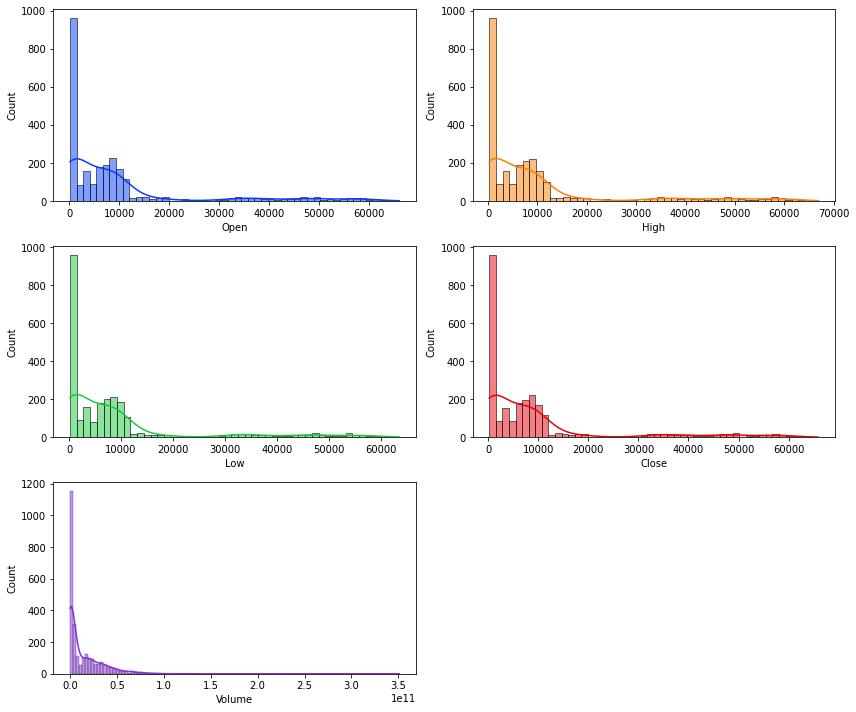

In [8]:
fig, axes = plt.subplots(3,2,figsize=(12,10))
axes = axes.flatten()

for i,j in enumerate(dfb.columns[1:]):
    ax = axes[i]
    ax = sns.histplot(dfb[j],color=sns.color_palette("bright",6)[i],kde=True,ax=ax)

ax = axes[i+1]
ax.axis('off')
fig.tight_layout()

### **Valores de features en Serie de Tiempo**

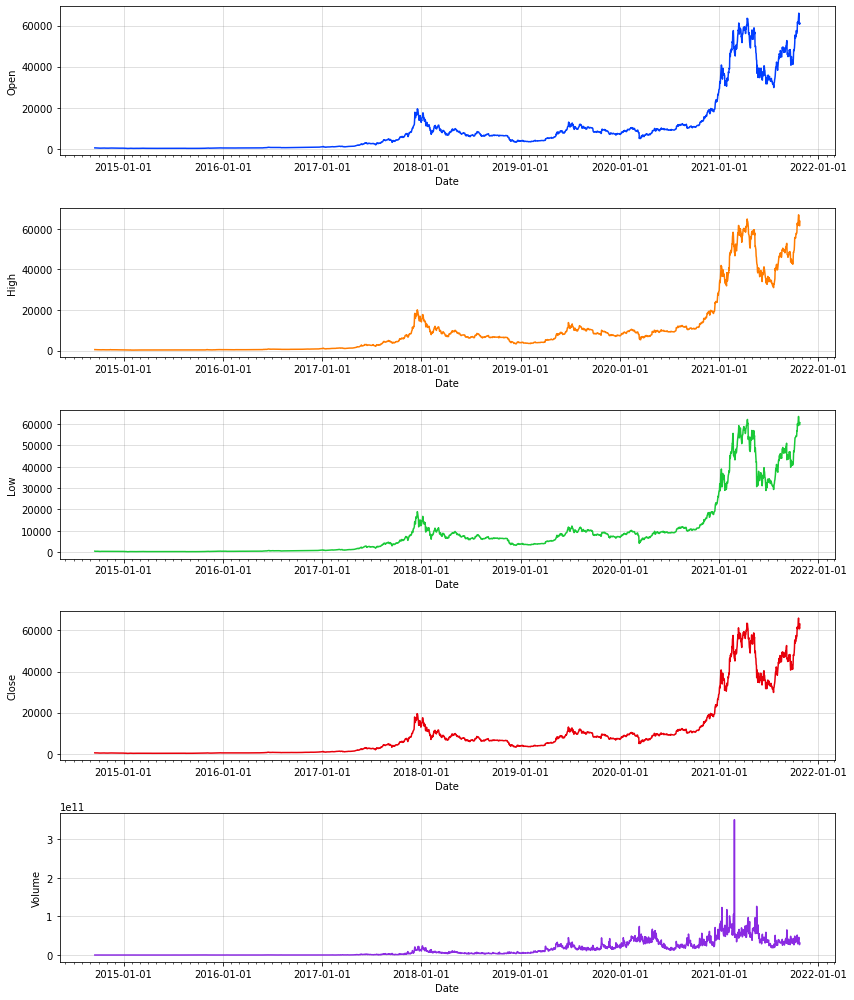

In [9]:
fig, axes = plt.subplots(5,1,figsize=(12,14))
axes = axes.flatten()

for i,j in enumerate(dfb.columns[1:]):
    ax = axes[i]
    ax.grid(color='gray',alpha=0.3)
    ax = sns.lineplot(x = dfb.Date,y = dfb[j],color=sns.color_palette("bright",6)[i],ax=ax)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.tick_params(axis='x', rotation=0)
    
fig.tight_layout()

### **Pairplot**

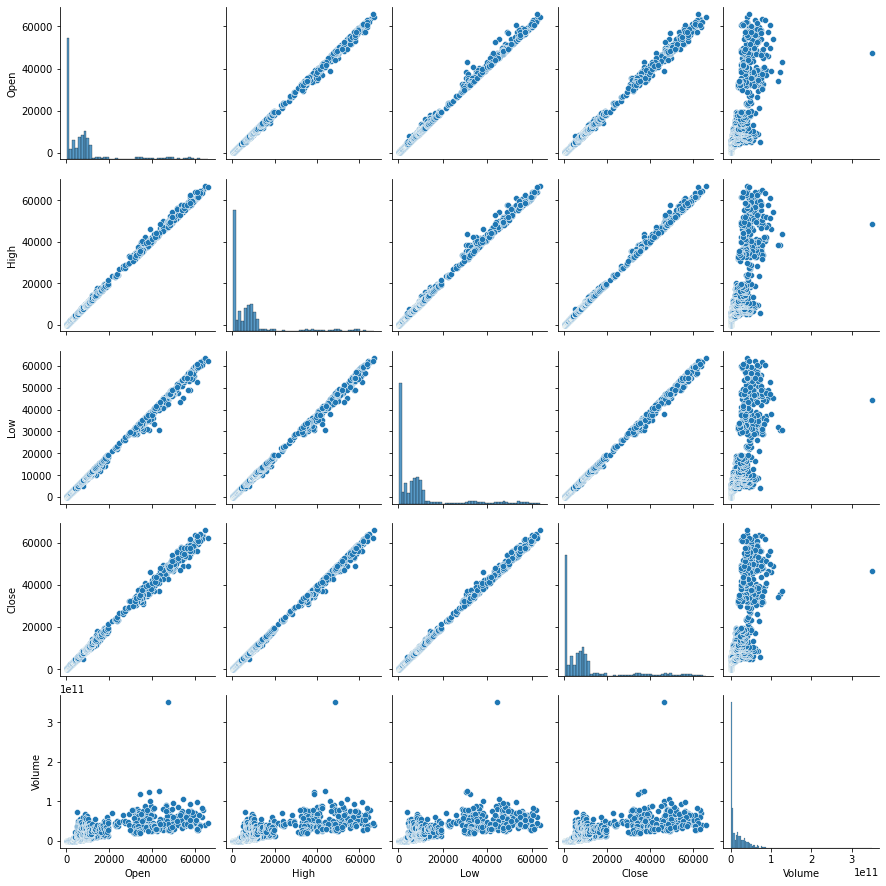

In [10]:
sns.pairplot(dfb[dfb.columns[1:]])

### **Heatmap de correlación**

<AxesSubplot:>

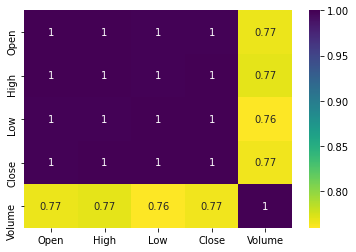

In [11]:
sns.heatmap(dfb[dfb.columns[1:]].corr('pearson'),annot=True,cmap='viridis_r')

### **Comentarios generales de los datos**
* **En general** todas las variables tienen **gran concentración de datos en los valores más cercanos a cero de la distribución**. Esto sucede porque en la serie de tiempo existe un gran intervalo desde el inicio en el que los valores eran pequeños con respecto al crecimiento exponencial que tuvo en el tiempo.
* De acuerdo a los **diagramas de caja** de High, Low, Open y Close; valores mayores a **23000 USD por bitcoin se considerarían como potencialmente atípicos**, pero esto es por lo mencionado anteriormente sobre la gran cantidad de tiempo en el que el bitcoin se encontró en valores bajos. Dado el contexto creciente de la tendencia, dichos valores por encima de 23000 USD no se descartarán al menos que se encuentre un cambio abrupto en la tendencia.
* Tal como se puede apreciar en el **heatmap de correlación y pairplot**, las variables **High, Low, Open y Close** están **enteramente correlacionadas entre sí**, de hecho, su correlación es 1. Con respecto a la variable **Volume**, la misma mantiene una **correlación positiva** con las demás variables pero en un rango de [0.76,0.77] , que de igual manera es una alta correlación.
* La variable **Volume** es la que posee una **distribución y tendencia más distinta con respecto a las demás**. Posee un posible **outlier** el cual se puede ver que triplica a los valores de la tendencia de forma abrupta y además se encuentra muy **separado del bigote en el diagrama de caja, así como del resto de valores potencialmente atípicos**.

---
## 3.- CURACIÓN Y PREPARACIÓN DE LOS DATOS
Tal como se demostró al inicio de la descripción de datos, no se cuentan con valores nulos ni duplicados. Por lo que se procede a la remoción del outlier dado por el valor atípico de Volume y luego directamente a la preparación de los datos de acuerdo al plan de acción:
* Se dividirá el conjunto **train/test**:
    * Test: Datos de los últimos 30 días
    * Train: Datos desde el inicio de la serie temporal hasta donde comienza el set de test


* Definir una **ventana de tiempo de 60 timesteps y una salida**, de forma que el valor a predecir dependa del valor del Bitcoin u otras variables de 60 días atrás. Para mayores detalles, referirse a la introducción, donde se encuentran explicadas a detalles las estructuras de datos.
    
    
* Probar distintas **estructuras de variables dependientes**:
    * **Estructura 1**: Utilizar sólo el valor de apertura de la acción del Bitcoin
        * A esta estructura se le agregará una prueba de concepto. La cual consistirá en predecir la ventana de 30 días sólo dependiendo del primer valor predicho, es decir, sin actualizar los valores de predicción mientras transcurre la línea de tiempo. Para mayor detalles, referirse a diagrama en la introducción.
    * **Estructura 2**: Utilizar valores de apertura, cierre, mínimo, máximo y volumen del bitcoin como variables dependientes.
    

* Valor a predecir: *Open*

### REMOCIÓN DE OUTLIERS

In [12]:
dfb

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07
...,...,...,...,...,...,...
2587,2021-10-21,66002.234375,66600.546875,62117.410156,62210.171875,4.590812e+10
2588,2021-10-22,62237.890625,63715.023438,60122.796875,60692.265625,3.843408e+10
2589,2021-10-23,60694.628906,61743.878906,59826.523438,61393.617188,2.688255e+10
2590,2021-10-24,61368.343750,61505.804688,59643.343750,60930.835938,2.731618e+10


In [13]:
dfb = dfb[dfb.Volume!=dfb.Volume.max()].reset_index(drop=True)
dfb

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07
...,...,...,...,...,...,...
2586,2021-10-21,66002.234375,66600.546875,62117.410156,62210.171875,4.590812e+10
2587,2021-10-22,62237.890625,63715.023438,60122.796875,60692.265625,3.843408e+10
2588,2021-10-23,60694.628906,61743.878906,59826.523438,61393.617188,2.688255e+10
2589,2021-10-24,61368.343750,61505.804688,59643.343750,60930.835938,2.731618e+10


### **DIVISIÓN TRAIN/TEST**
Se separa la serie de tiempo en train/test, dejando los últimos 30 días como set de test para comparar con las predicciones realizadas desde el set de train.

In [14]:
data_train = dfb[0:2561]
data_train

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07
...,...,...,...,...,...,...
2556,2021-09-21,43012.234375,43607.609375,39787.609375,40693.675781,4.870109e+10
2557,2021-09-22,40677.953125,43978.621094,40625.632813,43574.507813,3.813971e+10
2558,2021-09-23,43560.296875,44942.175781,43109.339844,44895.097656,3.424406e+10
2559,2021-09-24,44894.300781,45080.492188,40936.558594,42839.750000,4.283935e+10


In [15]:
data_test = dfb[2561:]
data_test

,Date,Open,High,Low,Close,Volume
2561,2021-09-26,42721.628906,43919.300781,40848.460938,43208.539063,3.066122e+10
2562,2021-09-27,43234.183594,44313.246094,42190.632813,42235.730469,3.098003e+10
2563,2021-09-28,42200.898438,42775.144531,40931.664063,41034.542969,3.021494e+10
2564,2021-09-29,41064.984375,42545.257813,40829.667969,41564.363281,3.060236e+10
2565,2021-09-30,41551.269531,44092.601563,41444.582031,43790.894531,3.114168e+10
2566,2021-10-01,43816.742188,48436.011719,43320.023438,48116.941406,4.285064e+10
2567,2021-10-02,48137.468750,48282.062500,47465.496094,47711.488281,3.061435e+10
2568,2021-10-03,47680.027344,49130.691406,47157.289063,48199.953125,2.663812e+10
2569,2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344,3.338317e+10
2570,2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500,3.587390e+10


In [16]:
data_test.shape

(30, 6)

### ESTRUCTURA DE VARIABLES #1
La estructura #1 sólo considerará la tendencia del propio valor "Open" para predecir sus valores futuros:
* A esta estructura se le agregará una prueba de concepto. La cual consistirá en predecir la ventana de 30 días sólo dependiendo del primer valor predicho, es decir, sin actualizar los valores de predicción mientras transcurre la línea de tiempo. Dicha prueba de concepto se implementará en el punto 5.

#### Se preparan los datos

In [17]:
training_set_1  = data_train.iloc[:, 1:2].values
training_set_1

array([[  465.864014],
       [  456.859985],
       [  424.102997],
       ...,
       [43560.296875],
       [44894.300781],
       [42840.890625]])

In [18]:
test_set  = data_test.iloc[:, 1:2].values
test_set

array([[42721.628906],
       [43234.183594],
       [42200.898438],
       [41064.984375],
       [41551.269531],
       [43816.742188],
       [48137.46875 ],
       [47680.027344],
       [48208.90625 ],
       [49174.960938],
       [51486.664063],
       [55338.625   ],
       [53802.144531],
       [53929.78125 ],
       [54952.820313],
       [54734.125   ],
       [57526.832031],
       [56038.257813],
       [57372.832031],
       [57345.902344],
       [61609.527344],
       [60887.652344],
       [61548.804688],
       [62043.164063],
       [64284.585938],
       [66002.234375],
       [62237.890625],
       [60694.628906],
       [61368.34375 ],
       [60893.925781]])

Se aplica MinMaxScaler para que las predicciones no estén afectadas por los rangos de los valores:

In [19]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled_1 = sc.fit_transform(training_set_1)
training_set_scaled_1

array([[0.00456166],
       [0.00441952],
       [0.00390242],
       ...,
       [0.68485481],
       [0.70591354],
       [0.67349819]])

In [20]:
training_set_scaled_1.shape

(2561, 1)

Se construye:
* **y_train1:** Contendrá los valores target "Open". Valores del t0 desde la serie temporal serán desde el día 60 hasta el día final.
* **X_train1:** Contendrá los valores de la ventana [t-60,t-1] respecto al t0 en y_train1, por lo tanto, 60 steps por fila. La cantidad de filas depende del tiempo abarcado, por lo que serán 2501 filas.

In [21]:
X_train1 = []
y_train1 = []
for i in range(60, 2561):
    X_train1.append(training_set_scaled_1[i-60:i, 0])
    y_train1.append(training_set_scaled_1[i, 0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)
X_train1

array([[0.00456166, 0.00441952, 0.00390242, ..., 0.00395246, 0.00381266,
        0.0035164 ],
       [0.00441952, 0.00390242, 0.00343783, ..., 0.00381266, 0.0035164 ,
        0.00312301],
       [0.00390242, 0.00343783, 0.00364956, ..., 0.0035164 , 0.00312301,
        0.003338  ],
       ...,
       [0.53851758, 0.55578344, 0.58565081, ..., 0.74328091, 0.67620304,
        0.63935384],
       [0.55578344, 0.58565081, 0.62080887, ..., 0.67620304, 0.63935384,
        0.68485481],
       [0.58565081, 0.62080887, 0.62857982, ..., 0.63935384, 0.68485481,
        0.70591354]])

Se verifica el *shape* y el orden de los datos en formato de steps de 60 días (Xtrain) con los datos originales escalados:

In [22]:
X_train1.shape

(2501, 60)

In [23]:
training_set_scaled_1[0:60,0]

array([0.00456166, 0.00441952, 0.00390242, 0.00343783, 0.00364956,
       0.00350772, 0.00355495, 0.0040863 , 0.00388747, 0.00370235,
       0.00357806, 0.00351358, 0.00315771, 0.00314445, 0.00332345,
       0.00326916, 0.00313013, 0.00288878, 0.00239979, 0.00226518,
       0.00242612, 0.00251345, 0.002776  , 0.00296447, 0.00291198,
       0.00293162, 0.00317339, 0.00339078, 0.003537  , 0.00343539,
       0.00324971, 0.00326897, 0.00338386, 0.00335193, 0.00324442,
       0.00330278, 0.00325296, 0.00286824, 0.00286856, 0.00269295,
       0.00280803, 0.00278337, 0.00284453, 0.00250702, 0.00265383,
       0.00255345, 0.00235494, 0.00234695, 0.00237208, 0.00242768,
       0.0025662 , 0.00272975, 0.00260876, 0.00265963, 0.00292624,
       0.00298294, 0.00301653, 0.00395246, 0.00381266, 0.0035164 ])

In [24]:
X_train1[0]

array([0.00456166, 0.00441952, 0.00390242, 0.00343783, 0.00364956,
       0.00350772, 0.00355495, 0.0040863 , 0.00388747, 0.00370235,
       0.00357806, 0.00351358, 0.00315771, 0.00314445, 0.00332345,
       0.00326916, 0.00313013, 0.00288878, 0.00239979, 0.00226518,
       0.00242612, 0.00251345, 0.002776  , 0.00296447, 0.00291198,
       0.00293162, 0.00317339, 0.00339078, 0.003537  , 0.00343539,
       0.00324971, 0.00326897, 0.00338386, 0.00335193, 0.00324442,
       0.00330278, 0.00325296, 0.00286824, 0.00286856, 0.00269295,
       0.00280803, 0.00278337, 0.00284453, 0.00250702, 0.00265383,
       0.00255345, 0.00235494, 0.00234695, 0.00237208, 0.00242768,
       0.0025662 , 0.00272975, 0.00260876, 0.00265963, 0.00292624,
       0.00298294, 0.00301653, 0.00395246, 0.00381266, 0.0035164 ])

In [25]:
np.unique(training_set_scaled_1[0:60,0] == X_train1[0])

array([ True])

In [26]:
np.unique(training_set_scaled_1[1:61,0] == X_train1[1])

array([ True])

In [27]:
np.unique(training_set_scaled_1[60:120,0] == X_train1[60])

array([ True])

Se verifica el *shape* de los datos de input. Se adaptan para su entrada a las capas de redes neuronales de Keras y se comprueba que el set haya quedado en la forma deseada:

In [28]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1))
X_train1.shape

(2501, 60, 1)

In [29]:
X_train1[0,:,0]

array([0.00456166, 0.00441952, 0.00390242, 0.00343783, 0.00364956,
       0.00350772, 0.00355495, 0.0040863 , 0.00388747, 0.00370235,
       0.00357806, 0.00351358, 0.00315771, 0.00314445, 0.00332345,
       0.00326916, 0.00313013, 0.00288878, 0.00239979, 0.00226518,
       0.00242612, 0.00251345, 0.002776  , 0.00296447, 0.00291198,
       0.00293162, 0.00317339, 0.00339078, 0.003537  , 0.00343539,
       0.00324971, 0.00326897, 0.00338386, 0.00335193, 0.00324442,
       0.00330278, 0.00325296, 0.00286824, 0.00286856, 0.00269295,
       0.00280803, 0.00278337, 0.00284453, 0.00250702, 0.00265383,
       0.00255345, 0.00235494, 0.00234695, 0.00237208, 0.00242768,
       0.0025662 , 0.00272975, 0.00260876, 0.00265963, 0.00292624,
       0.00298294, 0.00301653, 0.00395246, 0.00381266, 0.0035164 ])

In [30]:
np.unique(X_train1[0,:,0] == training_set_scaled_1[0:60,0])

array([ True])

Se prepara:
* **X_test1:** Se compone de una ventana de 30 días para evaluar cómo se comportaría el modelo a través del tiempo, y no basar los resultados en una sóla predicción. El primer valor contendrá los datos de [t-60,t-1], los cuales servirán para predecir el siguiente valor de la serie de tiempo. Luego se irán actualizando los valores con el set y_test (datos reales, no predichos), para que el modelo ejecute las predicciones con los valores actualizados y así abarcar la ventana de tiempo.

In [31]:
dataset_total_1 = pd.concat((data_train[data_train.columns[1:2]], data_test[data_test.columns[1:2]]), axis = 0)
inputs = dataset_total_1[len(dataset_total_1) - len(data_test) - 60:].values
#inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test_1 = []
for i in range(60, 90):
    X_test_1.append(inputs[i-60:i,0])
    
X_test_1 = np.array(X_test_1)
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], 1))
X_test_1.shape


(30, 60, 1)

### ESTRUCTURA DE VARIABLES #2
La estructura #2 considerará la tendencia de los valores Open, High, Low, Close y Volume para predecir el valor futuro de "Open".
#### Se preparan los datos

In [32]:
training_set_2  = data_train.iloc[:, 1:6].values
training_set_2

array([[4.65864014e+02, 4.68174011e+02, 4.52421997e+02, 4.57334015e+02,
        2.10568000e+07],
       [4.56859985e+02, 4.56859985e+02, 4.13104004e+02, 4.24440002e+02,
        3.44832000e+07],
       [4.24102997e+02, 4.27834991e+02, 3.84532013e+02, 3.94795990e+02,
        3.79197000e+07],
       ...,
       [4.35602969e+04, 4.49421758e+04, 4.31093398e+04, 4.48950977e+04,
        3.42440644e+10],
       [4.48943008e+04, 4.50804922e+04, 4.09365586e+04, 4.28397500e+04,
        4.28393457e+10],
       [4.28408906e+04, 4.29962578e+04, 4.17599219e+04, 4.27165938e+04,
        3.16047172e+10]])

In [33]:
test_set_2  = data_test.iloc[:, 1:6].values
test_set_2

array([[4.27216289e+04, 4.39193008e+04, 4.08484609e+04, 4.32085391e+04,
        3.06612221e+10],
       [4.32341836e+04, 4.43132461e+04, 4.21906328e+04, 4.22357305e+04,
        3.09800291e+10],
       [4.22008984e+04, 4.27751445e+04, 4.09316641e+04, 4.10345430e+04,
        3.02149406e+10],
       [4.10649844e+04, 4.25452578e+04, 4.08296680e+04, 4.15643633e+04,
        3.06023599e+10],
       [4.15512695e+04, 4.40926016e+04, 4.14445820e+04, 4.37908945e+04,
        3.11416819e+10],
       [4.38167422e+04, 4.84360117e+04, 4.33200234e+04, 4.81169414e+04,
        4.28506416e+10],
       [4.81374688e+04, 4.82820625e+04, 4.74654961e+04, 4.77114883e+04,
        3.06143465e+10],
       [4.76800273e+04, 4.91306914e+04, 4.71572891e+04, 4.81999531e+04,
        2.66381159e+10],
       [4.82089062e+04, 4.94567773e+04, 4.70450039e+04, 4.91129023e+04,
        3.33831730e+10],
       [4.91749609e+04, 5.18399844e+04, 4.90728398e+04, 5.15148125e+04,
        3.58739042e+10],
       [5.14866641e+04, 5.5568

Se aplica MinMaxScaler para que las predicciones no estén afectadas por los rangos de los valores:

In [34]:
sc2 = MinMaxScaler(feature_range = (0, 1))
training_set_scaled_2 = sc2.fit_transform(training_set_2)
training_set_scaled_2

array([[4.56166296e-03, 3.96655200e-03, 4.52810327e-03, 4.40946635e-03,
        1.19841458e-04],
       [4.41952444e-03, 3.79155143e-03, 3.89432496e-03, 3.89002176e-03,
        2.26103175e-04],
       [3.90241925e-03, 3.34260510e-03, 3.43376463e-03, 3.42189943e-03,
        2.53300964e-04],
       ...,
       [6.84854814e-01, 6.91871604e-01, 6.92127521e-01, 7.06146777e-01,
        2.70973945e-01],
       [7.05913536e-01, 6.94011024e-01, 6.57103821e-01, 6.73689830e-01,
        3.39000322e-01],
       [6.73498192e-01, 6.61772968e-01, 6.70375856e-01, 6.71745013e-01,
        2.50085132e-01]])

Se preparan:
* **y_train2:** Contendrá los valores target. Valores del t0 desde la serie temporal desde el día 60 hasta el día final de la variable "Open".
* **X_train2:** Contendrá los valores de la ventana [t-60,t-1] respecto al t0, el cual está posicionado en y_train2, por lo tanto, 60 steps por fila. La cantidad de filas depende del tiempo abarcado, por lo que serán 2501 filas. En este caso X_train2 tendrá una tercera dimensión con 5 variables, cada una correspondiente a las variables dependientes: Open, High, Low, Close, Volume.

Se verifica el *shape* de entrada para las capas de redes neuronales del modelo a implementar con la libería Keras.

In [35]:
X_train2 = []
y_train2 = []
for i in range(60, 2561):
    X_train2.append(training_set_scaled_2[i-60:i])
    y_train2.append(training_set_scaled_2[i,2])
    
X_train2, y_train2 = np.array(X_train2), np.array(y_train2)
X_train2.shape

(2501, 60, 5)

Se prepara:
* **X_test2:** Se compone de una ventana de 30 días para evaluar cómo se comportaría el modelo a través del tiempo, y no basar los resultados en una sóla predicción. El primer valor contendrá los datos de [t-60,t-1], los cuales servirán para predecir el siguiente valor de la serie de tiempo. Luego se irán actualizando los valores con el set y_test (datos reales, no predichos), para que el modelo ejecute las predicciones con los valores actualizados y así abarcar la ventana de tiempo.

In [36]:
dataset_total_2 = pd.concat((data_train[data_train.columns[1:6]], data_test[data_test.columns[1:6]]), axis = 0)
inputs2 = dataset_total_2[len(dataset_total_2) - len(data_test) - 60:].values
#inputs2 = inputs2.reshape(-1,5)
inputs2 = sc2.transform(inputs2)

X_test2 = []
for i in range(60, 90):
    X_test2.append(inputs2[i-60:i])

X_test2 = np.array(X_test2)
X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 5))

In [37]:
X_test2.shape

(30, 60, 5)

---
## 4.- PROPUESTA PARA ABORDAR EL PROBLEMA
* Se ha definido **ventana de tiempo de 60 timesteps y una salida**, de forma que el valor a predecir dependa del valor del Bitcoin u otras variables de 60 días atrás.


* Se han definido las **estructuras de variables dependientes**:
    * **Estructura 1**: Utilizar sólo el valor de apertura de la acción del Bitcoin
        * A esta estructura se le agregará una prueba de concepto. La cual consistirá en predecir la ventana de 30 días sólo dependiendo del primer valor predicho, es decir, sin actualizar los valores de predicción mientras transcurre la línea de tiempo
    * **Estructura 2**: Utilizar valores de apertura, cierre, mínimo, máximo y volumen como variables dependientes.
    

* Valor a predecir: *Open*


* Construir distintas **arquitecturas de Deep Learning**: 
    * Red Neuronal Densa
    * Red Neuronal Recurrente con una capa LSTM + Red Neuronal Densa
    * Red Neuronal Recurrente varias capas LSTM + Red Neuronal Densa

### 4.a Plataforma y librerías a utilizar
Se utilizará Jupyter Notebook con kernel Python 3 y las siguientes librerías: 
* numpy
* pandas
* matplotlib
* seaborn
* datetime
* sklearn para escalamiento MinMaxScaler
* keras para modelo Sequential
* keras para estructura de capas redes neuronales: Dense, LSTM, Dropout

### 4.b Arquitecturas a utilizar
#### 1. Red Neuronal Densa
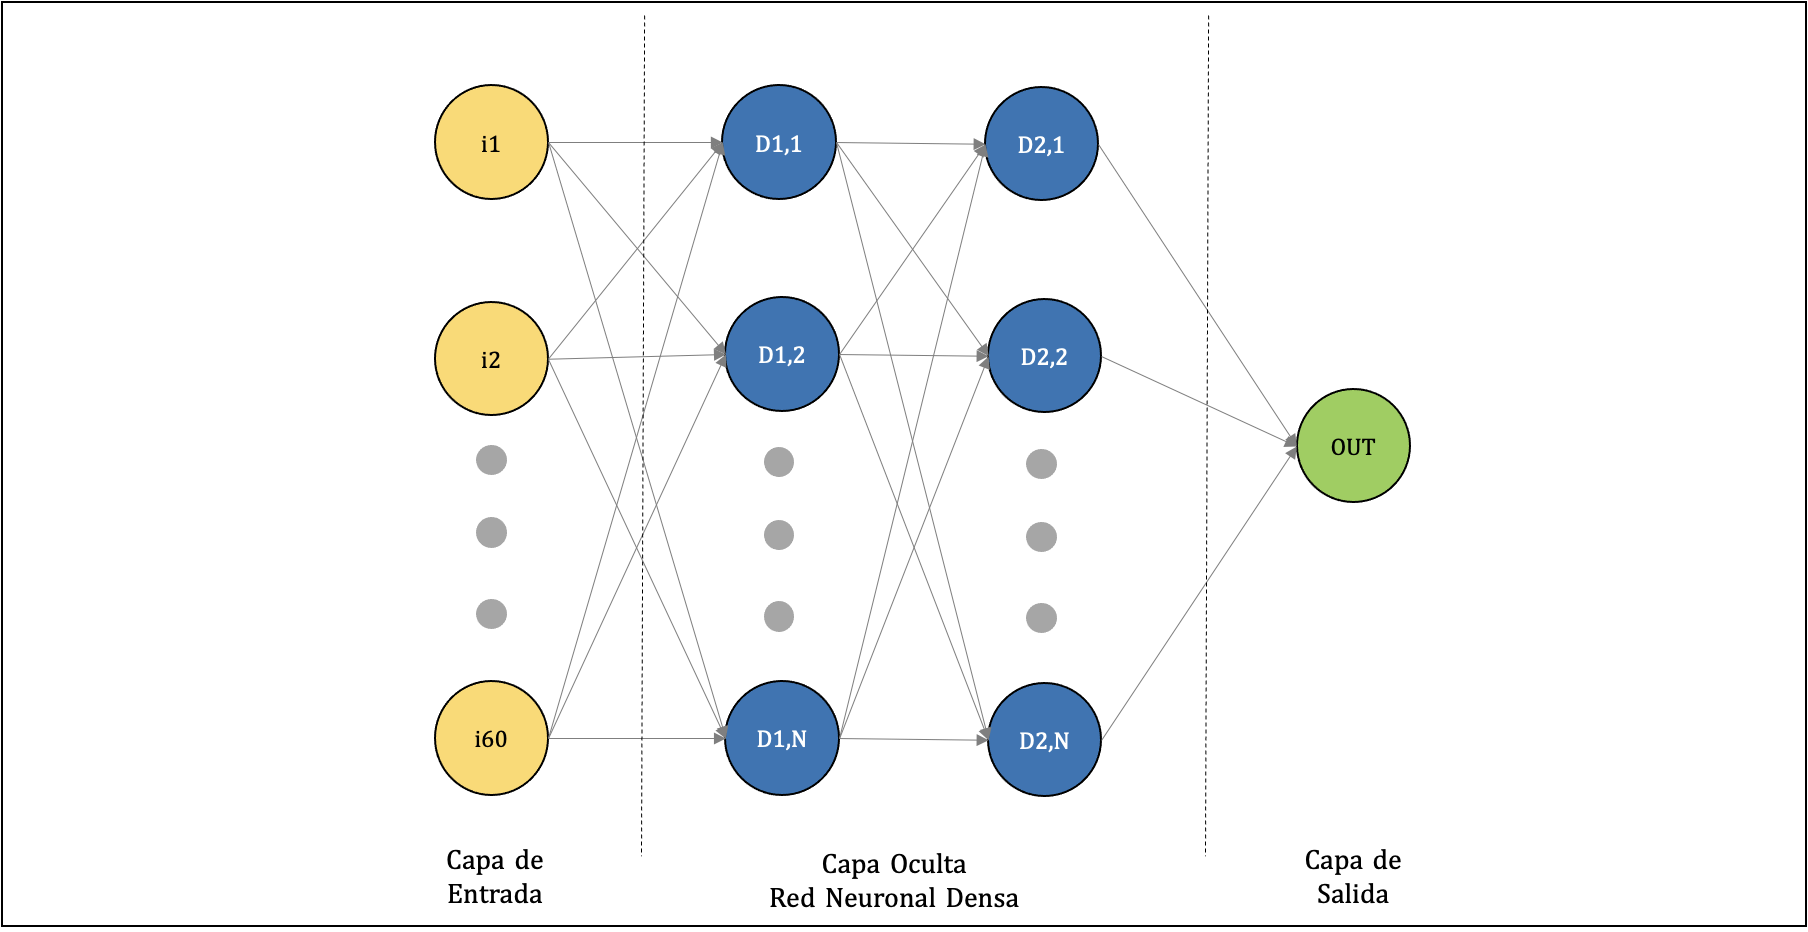

#### 2. Red Neuronal Recurrente con una capa LSTM + Red Neuronal Densa
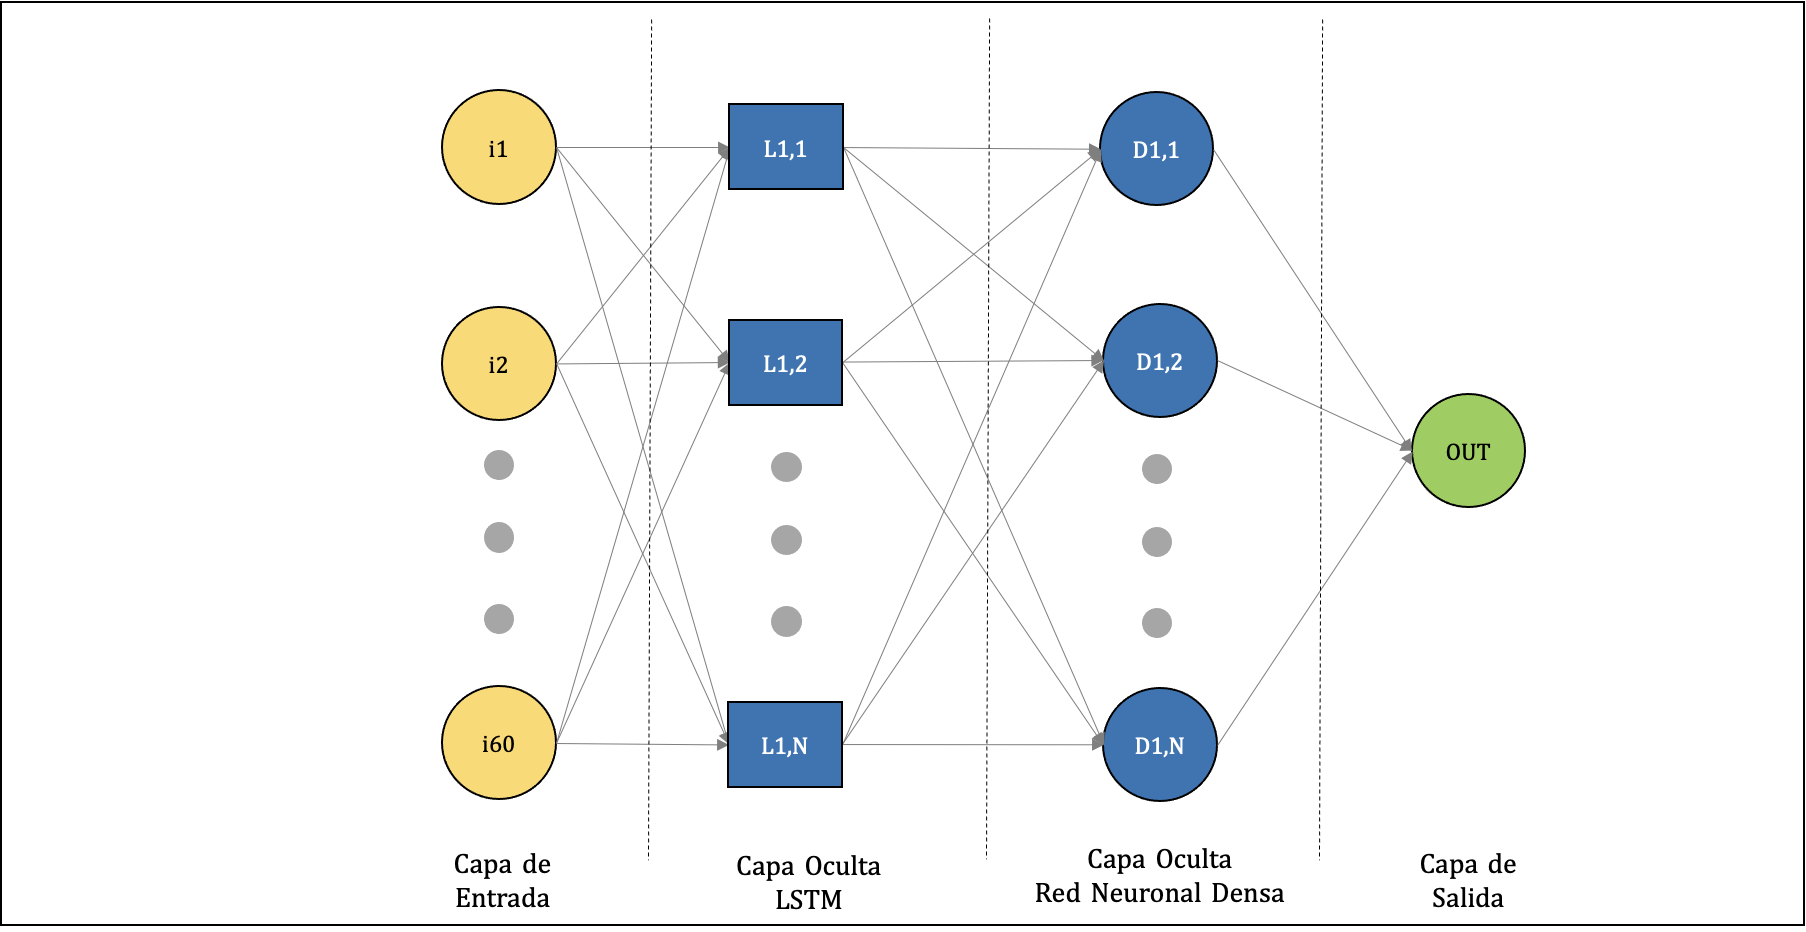

#### 3. Red Neuronal Recurrente varias capas LSTM + Red Neuronal Densa
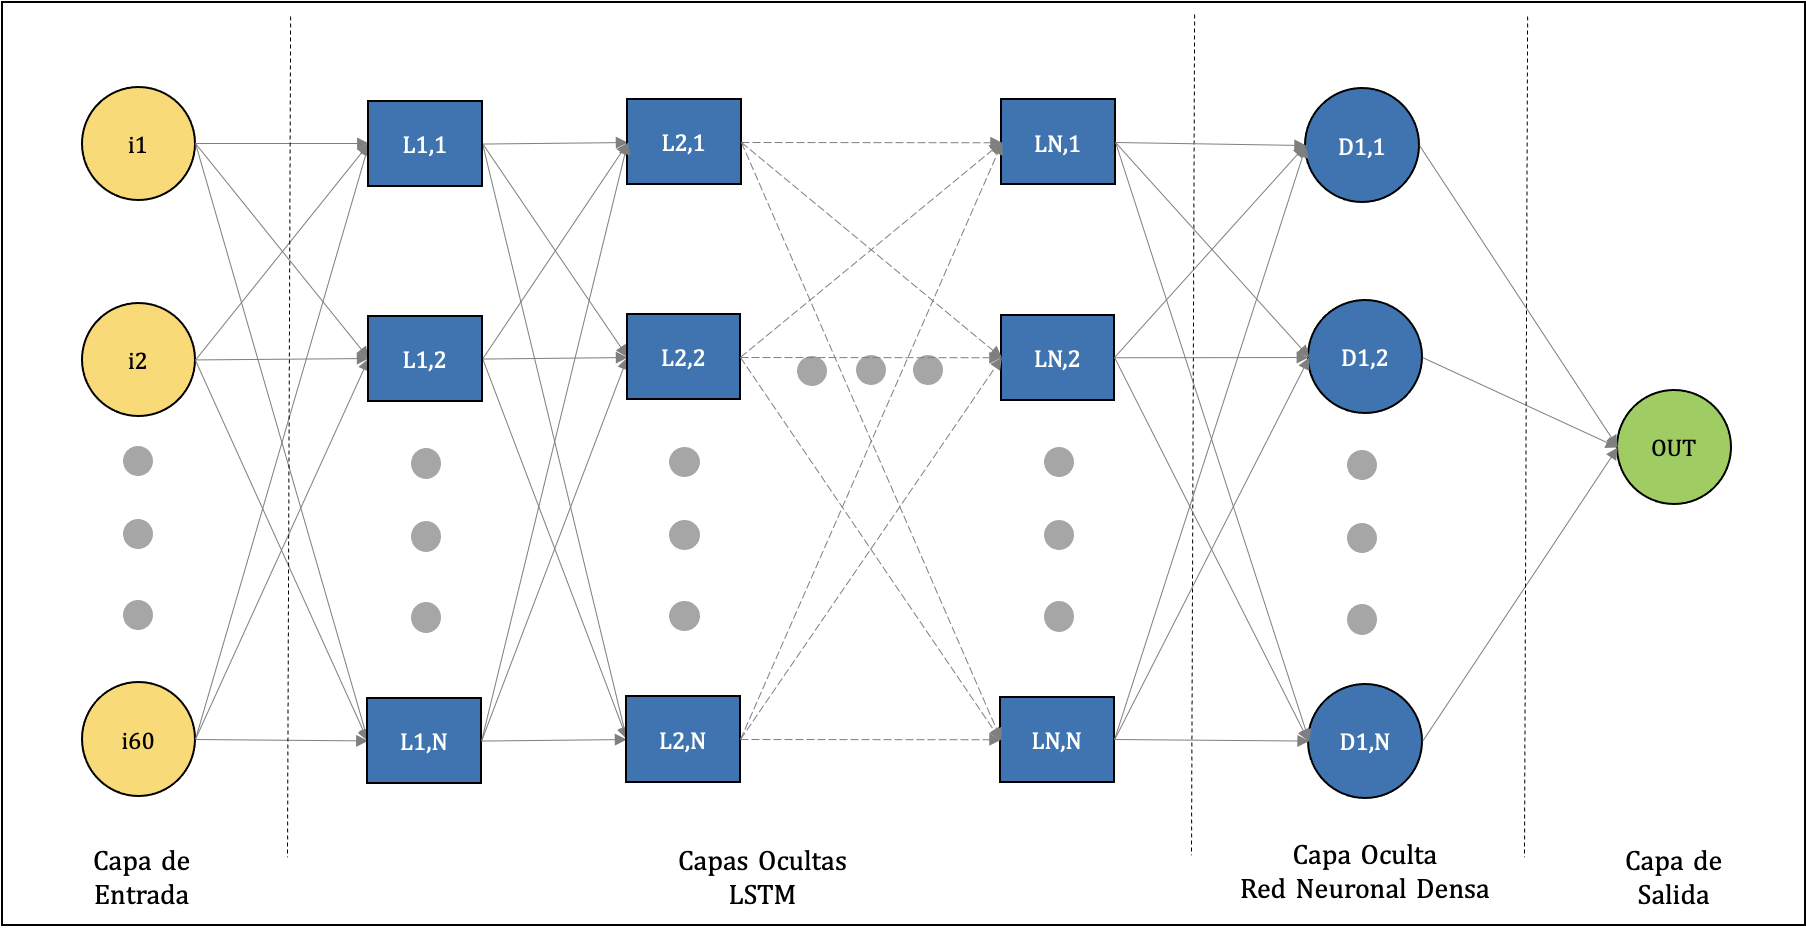

### 4.c Plan B
De no obtener los resultados deseados se considerará:
- Iteración sobre número de capas en las arquitecturas de las redes propuestas. Funciones de activación y de pérdida.
- Iteración sobre ventanas de steps de series de tiempo
- Añadir/Eliminar variables dependientes
- Indagar sobre otras estructuras de redes recurrentes (GRU, Bidireccionales)

---
## 5.- CONSTRUCCIÓN, FIT Y EVALUACIÓN DE LAS ARQUITECTURAS DE DEEP LEARNING




### 5.1 RED NEURONAL DENSA
Se construirá una Red Neuronal Densa con las siguientes características:
* Capa de entrada
* Dos capas ocultas de 32 neuronas
* Dropout 0.2
* Optimizador Adam
* Función de pérdida y métrica mean_squared_error

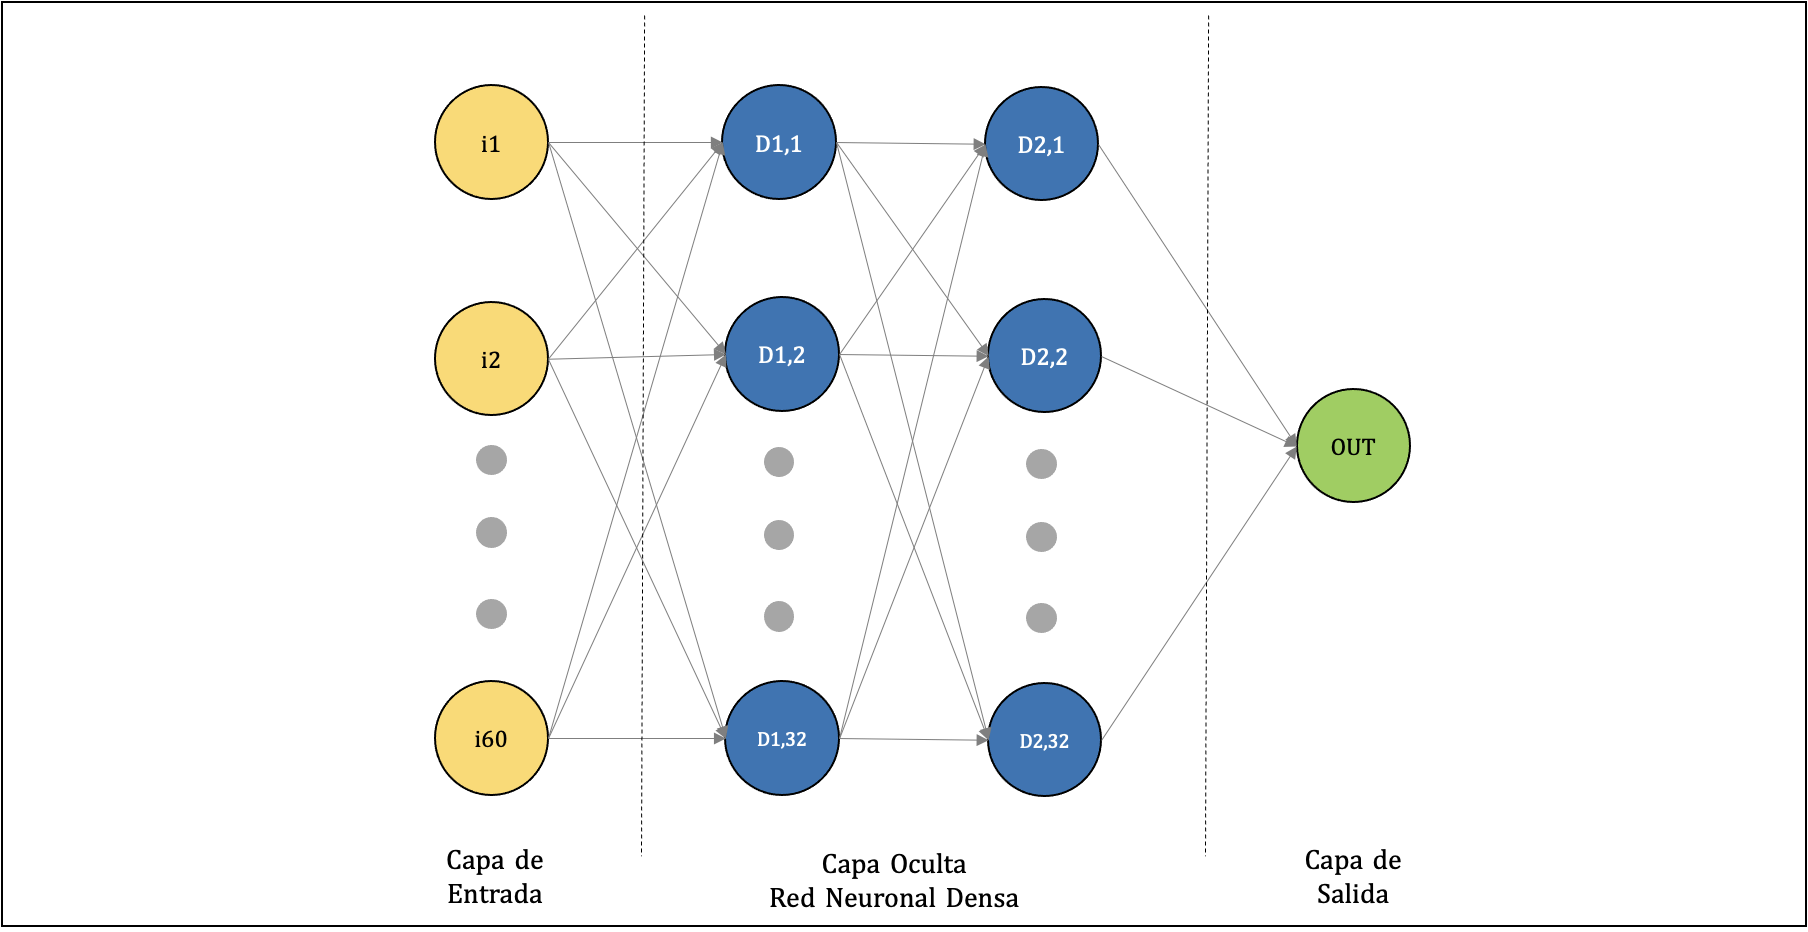

### 5.1.1 RED NEURONAL DENSA ESTRUCTURA 1

In [38]:
#Se fija semilla de aleatoriedad
seed(17)
set_seed(17)

#Se construye arquitectura
model_dense_s1 = Sequential()

model_dense_s1.add(Dense(32))
model_dense_s1.add(Dropout(0.2))

model_dense_s1.add(Dense(32))
model_dense_s1.add(Dropout(0.2))

model_dense_s1.add(Dense(1))

# Compilación
model_dense_s1.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

#Fit
model_dense_s1.fit(X_train1, y_train1, epochs=200, batch_size=32,verbose=1)

Epoch 1/200
79/79 [==============================] - 15s 1ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 2/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 3/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 4/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 5/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 6/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 7/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 8/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 9/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 10/200
79/79

79/79 [==============================] - 0s 1ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 150/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 151/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 152/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 153/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 154/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 155/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 156/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_squared_error: 0.0050  
Epoch 157/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 158/200

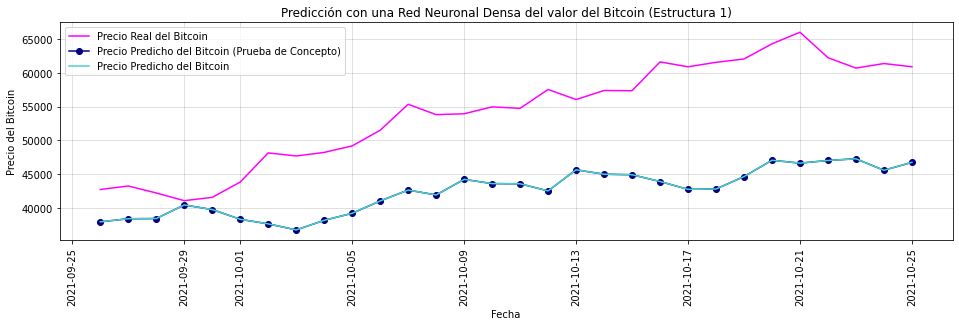

In [39]:
#Predicciones X_test1
predicted_bitcoin_price_xt1 = model_dense_s1.predict(X_test_1)[:,0,0].reshape(-1,1)
predicted_bitcoin_price_xt1 = sc.inverse_transform(predicted_bitcoin_price_xt1)

#Predicciones X_test2 (predicciones dependientes de la pasada predicción)
predicted_bitcoin_price_xt2 = np.array([[]])
first = data_train[data_train.columns[1:2]][-60:].values
first = sc.transform(first)
predicted_bitcoin_price_xt2 = np.append(predicted_bitcoin_price_xt2,model_dense_s1.predict(first.reshape(1,60,1))[:,0,0].reshape(-1,1))

for i in range(1,30):
    testx = data_train[data_train.columns[1:2]][i-60:].values
    testx = sc.transform(testx)
    testx = np.append(testx,predicted_bitcoin_price_xt2)
    predicted_bitcoin_price_xt2 = np.append(predicted_bitcoin_price_xt2,model_dense_s1.predict(testx.reshape(1,60,1))[:,0,0].reshape(-1,1))
predicted_bitcoin_price_xt2 = sc.inverse_transform(predicted_bitcoin_price_xt2.reshape(1,-1))

    
fig, axes = plt.subplots(1,1,figsize=(16,4))    
ax = axes
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1, color = 'navy',marker='o', label = 'Precio Predicho del Bitcoin (Prueba de Concepto)')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt2[0], color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una Red Neuronal Densa del valor del Bitcoin (Estructura 1)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()


RMSE predicciones:

In [40]:
mean_squared_error(test_set,predicted_bitcoin_price_xt1)**(1/2)

12598.641514056217

RMSE predicciones PoC:

In [41]:
mean_squared_error(test_set,predicted_bitcoin_price_xt2[0])**(1/2)

12598.642937854467

### 5.1.1 RED NEURONAL DENSA (ESTRUCTURA 2)

In [42]:
#Se fija semilla de aleatoriedad
seed(17)
set_seed(17)

#Se construye arquitectura
model_dense_s2 = Sequential()

model_dense_s2.add(Dense(32))#,input_shape = (X_train1.shape[1], 1)))
model_dense_s2.add(Dropout(0.2))

model_dense_s2.add(Dense(32))
model_dense_s2.add(Dropout(0.2))

model_dense_s2.add(Dense(1))

# Compilación
model_dense_s2.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

#Fit
model_dense_s2.fit(X_train2, y_train2, epochs=200, batch_size=32,verbose=1)

Epoch 1/200
79/79 [==============================] - 1s 1ms/step - loss: 0.0456 - mean_squared_error: 0.0456
Epoch 2/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 3/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 4/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 5/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 6/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 7/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 8/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 9/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 10/200
79/79 

79/79 [==============================] - 0s 1ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 150/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 151/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 152/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 153/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 154/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 155/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 156/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 157/200
79/79 [==============================] - 0s 1ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 158/200
7

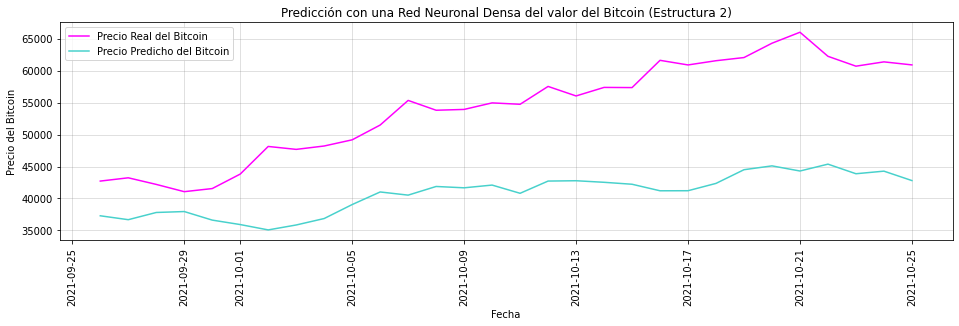

In [43]:
#Predicciones X_test1
predicted_bitcoin_price_xt1_dense_s2 = model_dense_s2.predict(X_test2)[:,0,0].reshape(-1,1)
predicted_bitcoin_price_xt1_dense_s2 = sc.inverse_transform(predicted_bitcoin_price_xt1_dense_s2)
    
fig, axes = plt.subplots(1,1,figsize=(16,4))    
ax = axes
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_dense_s2, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una Red Neuronal Densa del valor del Bitcoin (Estructura 2)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

RMSE predicciones:

In [44]:
mean_squared_error(test_set,predicted_bitcoin_price_xt1_dense_s2)**(1/2)

14212.488354206991

## 5.2 RED NEURONAL RECURRENTE CON UNA CAPA LSTM
* El plan inicial consistía en construir una RNR LSTM + Red Neuronal Densa, pero se obtuvo mejores resultados conectando directamente la capa LSTM a la capa de salida.
* Se utilizará una capa LSTM con 50 unidades, con dropout de 0.2 conectada a la capa de salida
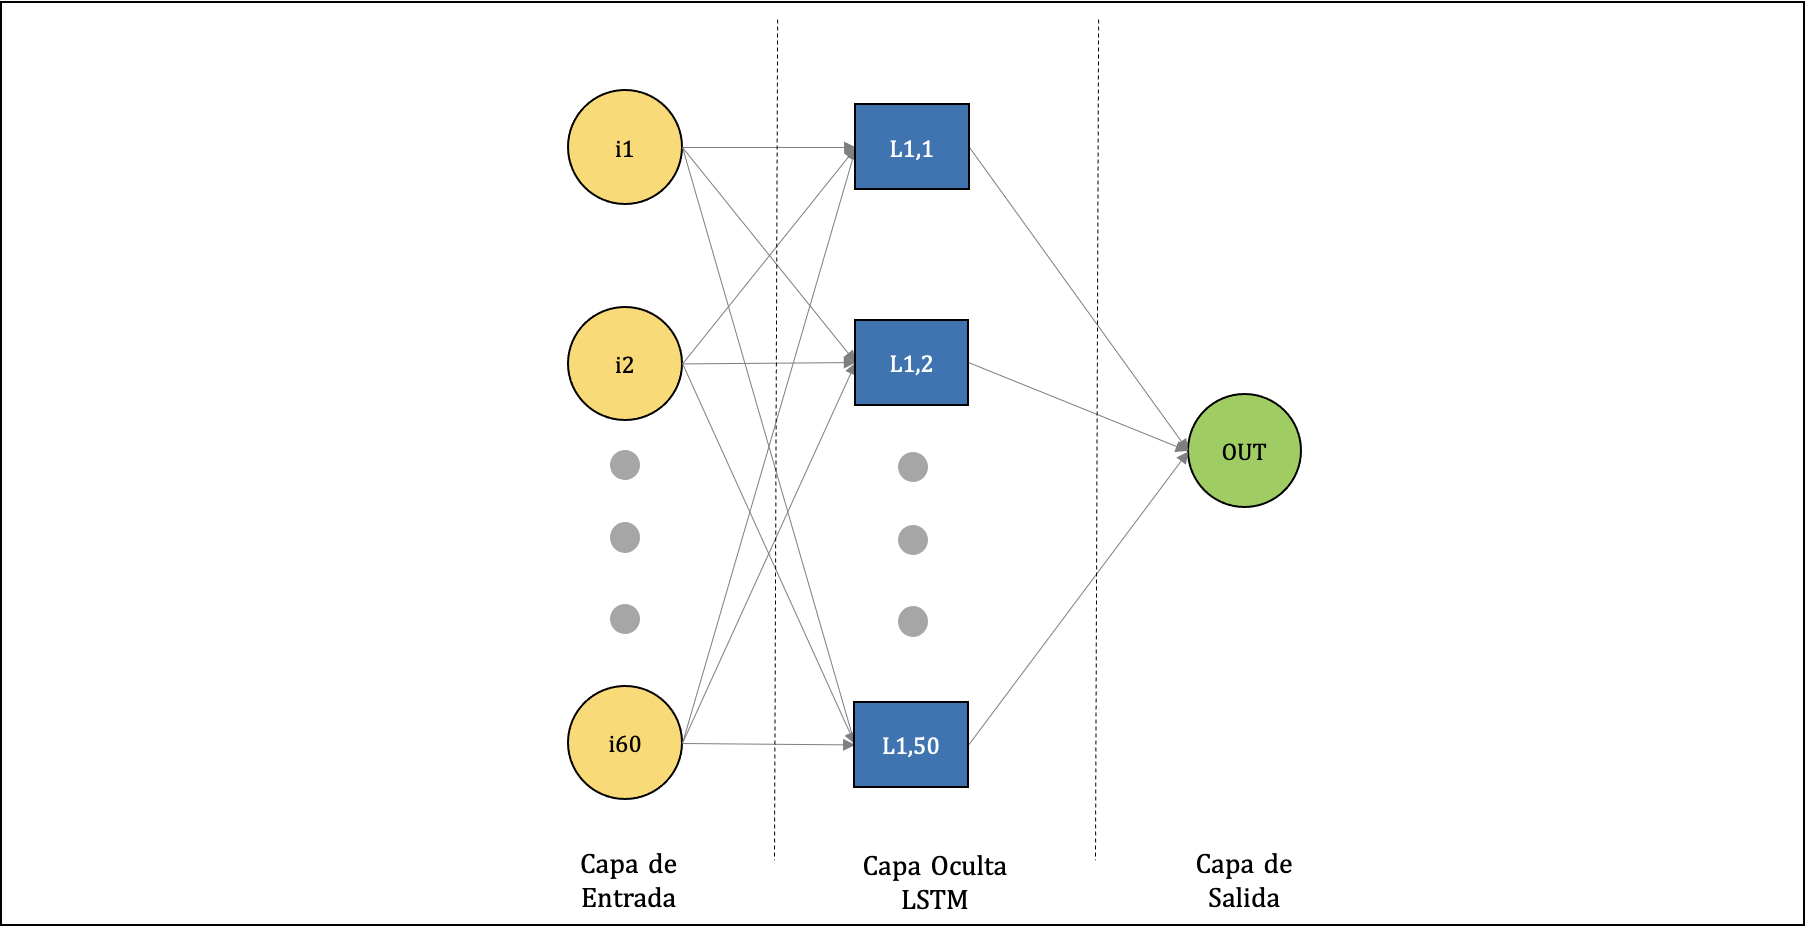

### 5.2.1 RED NEURONAL RECURRENTE CON UNA CAPA LSTM (ESTRUCTURA 1)

In [45]:
#Se fija semilla de aleatoriedad
seed(17)
set_seed(17)

#Se construye arquitectura
model_lstm1_s1 = Sequential()

model_lstm1_s1.add(LSTM(units = 50, input_shape = (X_train1.shape[1], X_train1.shape[2])))
model_lstm1_s1.add(Dropout(0.2))
#model_lstm1_s1.add(Dense(32))
#model_lstm1_s1.add(Dropout(0.2))
model_lstm1_s1.add(Dense(1))

# Compilación
model_lstm1_s1.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

#Fit
model_lstm1_s1.fit(X_train1, y_train1, epochs=100, batch_size=32,verbose=1)

Epoch 1/100
79/79 [==============================] - 4s 12ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 2/100
79/79 [==============================] - 1s 12ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 3/100
79/79 [==============================] - 1s 12ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 4/100
79/79 [==============================] - 1s 12ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 5/100
79/79 [==============================] - 1s 12ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 6/100
79/79 [==============================] - 1s 12ms/step - loss: 9.4893e-04 - mean_squared_error: 9.4893e-04
Epoch 7/100
79/79 [==============================] - 1s 12ms/step - loss: 8.7144e-04 - mean_squared_error: 8.7144e-04
Epoch 8/100
79/79 [==============================] - 1s 12ms/step - loss: 8.6441e-04 - mean_squared_error: 8.6441e-04
Epoch 9/100
79/79 [==============================] - 1s 11ms/step - loss: 7.4380e-04 - mean_squa

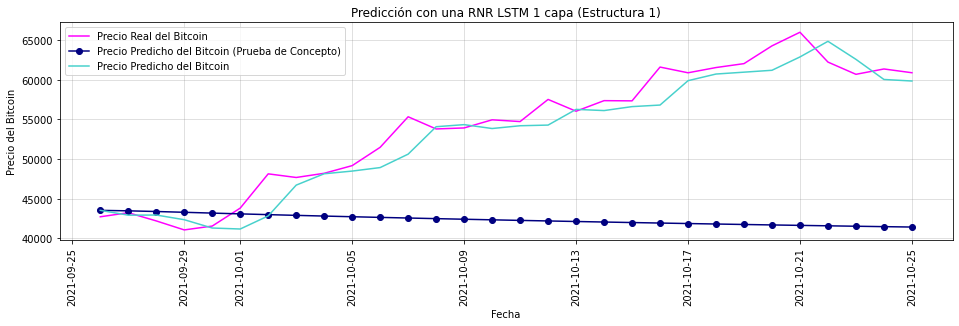

In [46]:
#Predicciones X_test1
predicted_bitcoin_price_xt1_lstm1_s1 = model_lstm1_s1.predict(X_test_1)
predicted_bitcoin_price_xt1_lstm1_s1 = sc.inverse_transform(predicted_bitcoin_price_xt1_lstm1_s1)

#Predicciones X_test2 (predicciones dependientes de la pasada predicción)
predicted_bitcoin_price_xt2_lstm1_s1 = np.array([[]])
first = data_train[data_train.columns[1:2]][-60:].values
first = sc.transform(first)
predicted_bitcoin_price_xt2_lstm1_s1 = np.append(predicted_bitcoin_price_xt2_lstm1_s1,model_lstm1_s1.predict(first.reshape(1,-1,1)))

cnt=0
for i in range(1,30):
    testx = data_train[data_train.columns[1:2]][i-60:].values
    testx = sc.transform(testx)
    testx = np.append(testx,predicted_bitcoin_price_xt2_lstm1_s1)
    predicted_bitcoin_price_xt2_lstm1_s1 = np.append(predicted_bitcoin_price_xt2_lstm1_s1,model_lstm1_s1.predict(testx.reshape(1,-1,1)))
predicted_bitcoin_price_xt2_lstm1_s1 = sc.inverse_transform(predicted_bitcoin_price_xt2_lstm1_s1.reshape(1,-1))

    
fig, axes = plt.subplots(1,1,figsize=(16,4))    
ax = axes
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt2_lstm1_s1[0], color = 'navy',marker='o', label = 'Precio Predicho del Bitcoin (Prueba de Concepto)')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_lstm1_s1, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una RNR LSTM 1 capa (Estructura 1)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

RMSE predicciones:

In [47]:
mean_squared_error(test_set,predicted_bitcoin_price_xt1_lstm1_s1)**(1/2)

2167.4456643451977

RMSE predicciones PoC:

In [48]:
mean_squared_error(test_set,predicted_bitcoin_price_xt2_lstm1_s1[0])**(1/2)

14222.517783125104

### 5.2.2 RED NEURONAL RECURRENTE CON UNA CAPA LSTM (ESTRUCTURA 2)

In [49]:
#Se fija semilla de aleatoriedad
seed(17)
set_seed(17)

#Se construye arquitectura
model_lstm1_s2 = Sequential()

model_lstm1_s2.add(LSTM(units = 50, input_shape = (X_train2.shape[1], X_train2.shape[2])))
model_lstm1_s2.add(Dropout(0.2))
model_lstm1_s2.add(Dense(1))

# Compilación
model_lstm1_s2.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

#Fit
model_lstm1_s2.fit(X_train2, y_train2, epochs=100, batch_size=32,verbose=1)

Epoch 1/100
79/79 [==============================] - 2s 11ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 2/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/100
79/79 [==============================] - 1s 11ms/step - loss: 8.4127e-04 - mean_squared_error: 8.4127e-04
Epoch 5/100
79/79 [==============================] - 1s 11ms/step - loss: 9.3984e-04 - mean_squared_error: 9.3984e-04
Epoch 6/100
79/79 [==============================] - 1s 11ms/step - loss: 7.3905e-04 - mean_squared_error: 7.3905e-04
Epoch 7/100
79/79 [==============================] - 1s 11ms/step - loss: 6.6450e-04 - mean_squared_error: 6.6450e-04
Epoch 8/100
79/79 [==============================] - 1s 11ms/step - loss: 6.4842e-04 - mean_squared_error: 6.4842e-04
Epoch 9/100
79/79 [==============================] - 1s 11ms/step - loss: 6.4903

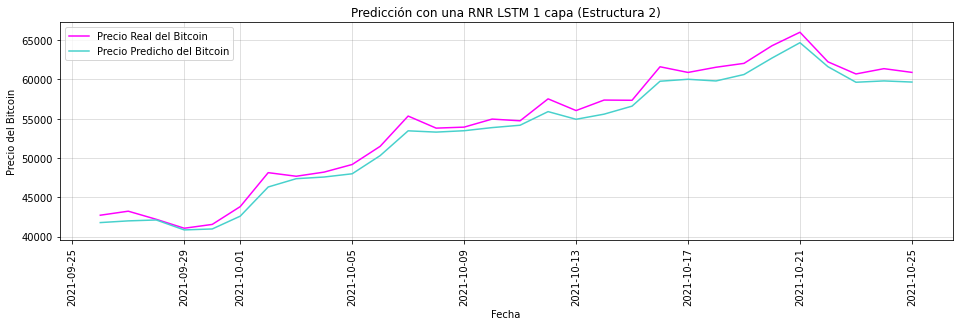

In [50]:
#Predicciones X_test1
predicted_bitcoin_price_xt1_lstm_s2 = model_lstm1_s2.predict(X_test2)
predicted_bitcoin_price_xt1_lstm_s2 = sc.inverse_transform(predicted_bitcoin_price_xt1_lstm_s2)
    
fig, axes = plt.subplots(1,1,figsize=(16,4))    
ax = axes
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_lstm_s2, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una RNR LSTM 1 capa (Estructura 2)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

RMSE predicciones:

In [51]:
mean_squared_error(test_set,predicted_bitcoin_price_xt1_lstm_s2)**(1/2)

1195.2101856277916

## 5.3 RED NEURONAL RECURRENTE CON 4 CAPAS LSTM
* El plan inicial consistía en construir una RNR LSTM + Red Neuronal Densa, pero se obtuvo mejores resultados conectando directamente la capa LSTM a la capa de salida.
* Se utilizarán 4 capas LSTM de 50 unidades, con dropout de 0.2 y una capa de salida.
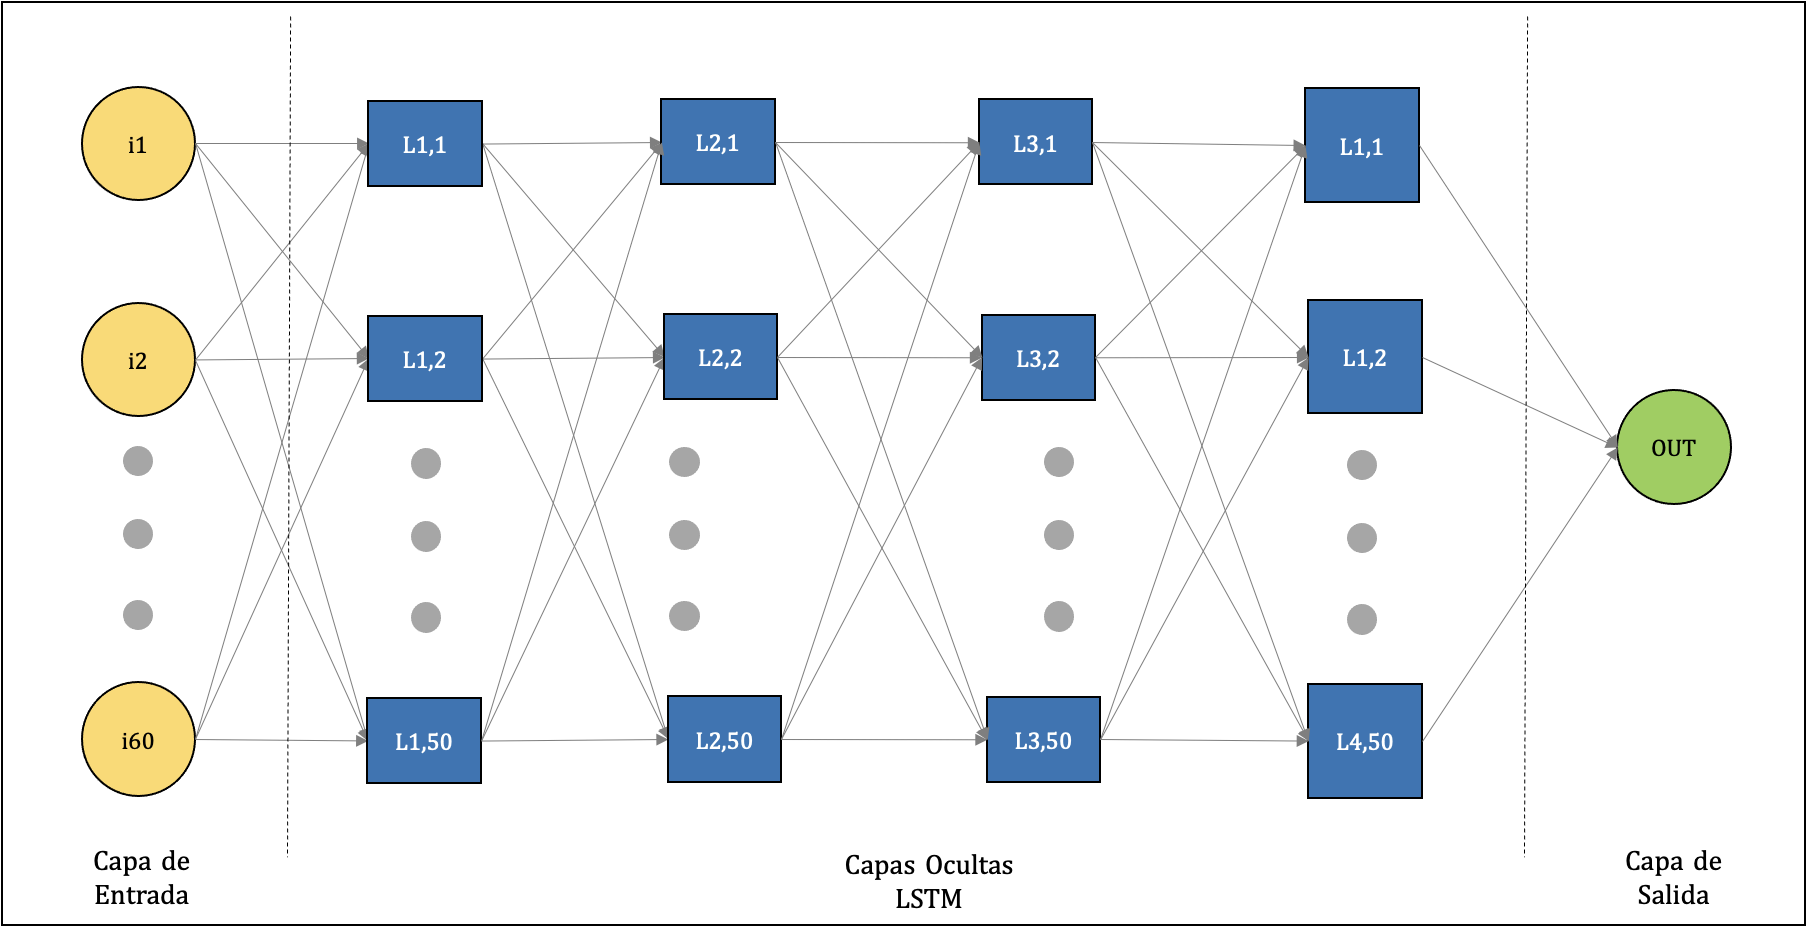

### 5.3.1 RED NEURONAL RECURRENTE CON 4 CAPAS LSTM (ESTRUCTURA 1)

In [52]:
#Se fija semilla de aleatoriedad
seed(17)
set_seed(17)

#Se construye arquitectura
model_lstm2_s1 = Sequential()

model_lstm2_s1.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train1.shape[1], X_train1.shape[2])))
model_lstm2_s1.add(Dropout(0.2))
model_lstm2_s1.add(LSTM(units = 50, return_sequences = True ))
model_lstm2_s1.add(Dropout(0.2))
model_lstm2_s1.add(LSTM(units = 50, return_sequences = True ))
model_lstm2_s1.add(Dropout(0.2))
model_lstm2_s1.add(LSTM(units = 50))
model_lstm2_s1.add(Dropout(0.2))
model_lstm2_s1.add(Dense(1))

# Compilación
model_lstm2_s1.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

#Fit
model_lstm2_s1.fit(X_train1, y_train1, epochs=100, batch_size=32,verbose=1)

Epoch 1/100
79/79 [==============================] - 8s 50ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 2/100
79/79 [==============================] - 4s 50ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/100
79/79 [==============================] - 4s 52ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 4/100
79/79 [==============================] - 4s 51ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 5/100
79/79 [==============================] - 4s 52ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 6/100
79/79 [==============================] - 4s 50ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 7/100
79/79 [==============================] - 4s 49ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 8/100
79/79 [==============================] - 4s 48ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 9/100
79/79 [==============================] - 4s 48ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 10/1

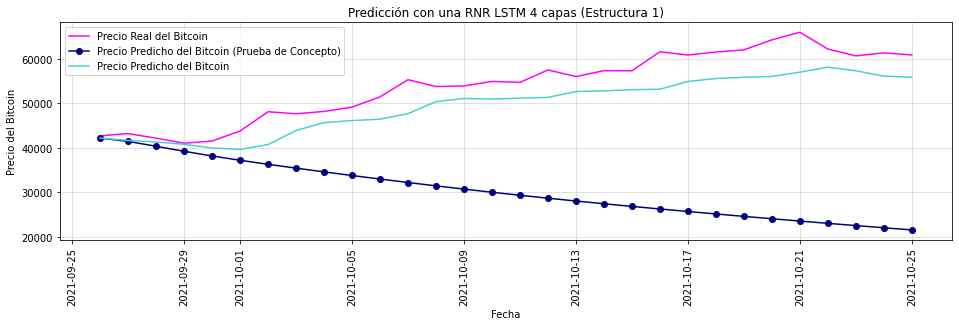

In [53]:
#Predicciones X_test1
predicted_bitcoin_price_xt1_lstm2_s1 = model_lstm2_s1.predict(X_test_1)
predicted_bitcoin_price_xt1_lstm2_s1 = sc.inverse_transform(predicted_bitcoin_price_xt1_lstm2_s1)

#Predicciones X_test2 (predicciones dependientes de la pasada predicción)
predicted_bitcoin_price_xt2_lstm2_s1 = np.array([[]])
first = data_train[data_train.columns[1:2]][-60:].values
first = sc.transform(first)
predicted_bitcoin_price_xt2_lstm2_s1 = np.append(predicted_bitcoin_price_xt2_lstm2_s1,model_lstm2_s1.predict(first.reshape(1,-1,1)))

for i in range(1,30):
    testx = data_train[data_train.columns[1:2]][i-60:].values
    testx = sc.transform(testx)
    testx = np.append(testx,predicted_bitcoin_price_xt2_lstm2_s1)
    predicted_bitcoin_price_xt2_lstm2_s1 = np.append(predicted_bitcoin_price_xt2_lstm2_s1,model_lstm2_s1.predict(testx.reshape(1,-1,1)))

predicted_bitcoin_price_xt2_lstm2_s1 = sc.inverse_transform(predicted_bitcoin_price_xt2_lstm2_s1.reshape(1,-1))

    
fig, axes = plt.subplots(1,1,figsize=(16,4))    
ax = axes
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt2_lstm2_s1[0], color = 'navy',marker='o', label = 'Precio Predicho del Bitcoin (Prueba de Concepto)')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_lstm2_s1, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una RNR LSTM 4 capas (Estructura 1)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

RMSE predicciones:

In [54]:
mean_squared_error(test_set,predicted_bitcoin_price_xt1_lstm2_s1)**(1/2)

4944.8473353776235

RMSE predicciones PoC:

In [55]:
mean_squared_error(test_set,predicted_bitcoin_price_xt2_lstm2_s1[0])**(1/2)

27131.79568346399

### 5.3.2 RED NEURONAL RECURRENTE CON 4 CAPAS LSTM (ESTRUCTURA 2)


In [56]:
#Se fija semilla de aleatoriedad
seed(17)
set_seed(17)

#Se construye arquitectura
model_lstm2_s2 = Sequential()

model_lstm2_s2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train2.shape[1], X_train2.shape[2])))
model_lstm2_s2.add(Dropout(0.2))
model_lstm2_s2.add(LSTM(units = 50, return_sequences = True ))
model_lstm2_s2.add(Dropout(0.2))
model_lstm2_s2.add(LSTM(units = 50, return_sequences = True ))
model_lstm2_s2.add(Dropout(0.2))
model_lstm2_s2.add(LSTM(units = 50))
model_lstm2_s2.add(Dropout(0.2))
model_lstm2_s2.add(Dense(1))

# Compilación
model_lstm2_s2.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

#Fit
model_lstm2_s2.fit(X_train2, y_train2, epochs=100, batch_size=32,verbose=1)

Epoch 1/100
79/79 [==============================] - 8s 51ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 2/100
79/79 [==============================] - 4s 49ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/100
79/79 [==============================] - 4s 49ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 4/100
79/79 [==============================] - 4s 51ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 5/100
79/79 [==============================] - 4s 51ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 6/100
79/79 [==============================] - 4s 51ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 7/100
79/79 [==============================] - 4s 50ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 8/100
79/79 [==============================] - 4s 51ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 9/100
79/79 [==============================] - 4s 51ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 10/1

79/79 [==============================] - 4s 48ms/step - loss: 6.7837e-04 - mean_squared_error: 6.7837e-04
Epoch 72/100
79/79 [==============================] - 4s 48ms/step - loss: 5.9465e-04 - mean_squared_error: 5.9465e-04
Epoch 73/100
79/79 [==============================] - 4s 48ms/step - loss: 4.9302e-04 - mean_squared_error: 4.9302e-04
Epoch 74/100
79/79 [==============================] - 4s 48ms/step - loss: 6.0570e-04 - mean_squared_error: 6.0570e-04
Epoch 75/100
79/79 [==============================] - 4s 48ms/step - loss: 6.0599e-04 - mean_squared_error: 6.0599e-04
Epoch 76/100
79/79 [==============================] - 4s 48ms/step - loss: 6.2275e-04 - mean_squared_error: 6.2275e-04
Epoch 77/100
79/79 [==============================] - 4s 48ms/step - loss: 6.2427e-04 - mean_squared_error: 6.2427e-04
Epoch 78/100
79/79 [==============================] - 4s 48ms/step - loss: 7.1601e-04 - mean_squared_error: 7.1601e-04
Epoch 79/100
79/79 [==============================] - 4s 48ms

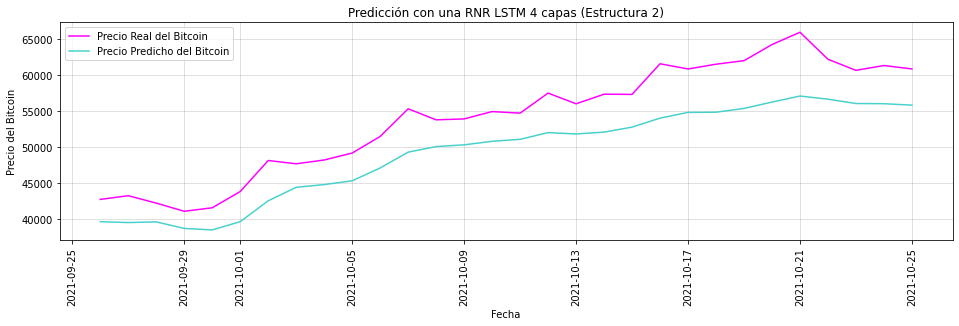

In [57]:
#Predicciones X_test1
predicted_bitcoin_price_xt1_lstm2_s2 = model_lstm2_s2.predict(X_test2)
predicted_bitcoin_price_xt1_lstm2_s2 = sc.inverse_transform(predicted_bitcoin_price_xt1_lstm2_s2)
    
fig, axes = plt.subplots(1,1,figsize=(16,4))    
ax = axes
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_lstm2_s2, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una RNR LSTM 4 capas (Estructura 2)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

RMSE predicciones:

In [58]:
mean_squared_error(test_set,predicted_bitcoin_price_xt1_lstm2_s2)**(1/2)

5079.43332789609

---
### 6.- SUMARIZACIÓN Y ANÁLISIS DE RESULTADOS
En resumen, se utilizaron 3 arquitecturas de deep learning:
* **Dense:** Red Neuronal Densa de 2 capas ocultas
* **LSTM_1:** Red Neuronal Recurrente con una capa LSTM y capa de salida
* **LSTM_4:** Red Neuronal Recurrente con cuatro capas LSTM y capa de salida

Cada arquitectura de deep learning fue construida con dos estructuras de datos.
* **E1**: Utilizar sólo el valor de apertura de la acción del Bitcoin
* **E2**: Utilizar valores de apertura, cierre, mínimo, máximo y volumen como variables dependientes.

Adicionalmente se ejecutó una prueba de concepto con la estructura 1 (**E1_PoC**). La razón principal de esta PoC era comprobar si alguna de las arquitecturas permitiría predecir los próximos 30 días de tendencia sin agregar los valores verdaderos al vector X_test mientras va avanzando la ventana de tiempo, sino tomando como valor real para avanzar el mismo valor predicho. Dicho método sólo pudo aplicarse a la estructura 1 ya que la misma variable target era la misma variable dependiente de 60 días atrás en el tiempo t0 de predicción, y no pudo ser aplicada en la estructura 2 porque habría que haber predicho las demás variables dependientes para añadirlas al vector X_test, de modo de ir prediciendo la variable target de manera continua.

A continuación, se procede a graficar en conjunto los resultados de las predicciones obtenidas para los 30 días después del set de train, con la finalidad de condensar el análisis de resultados final.

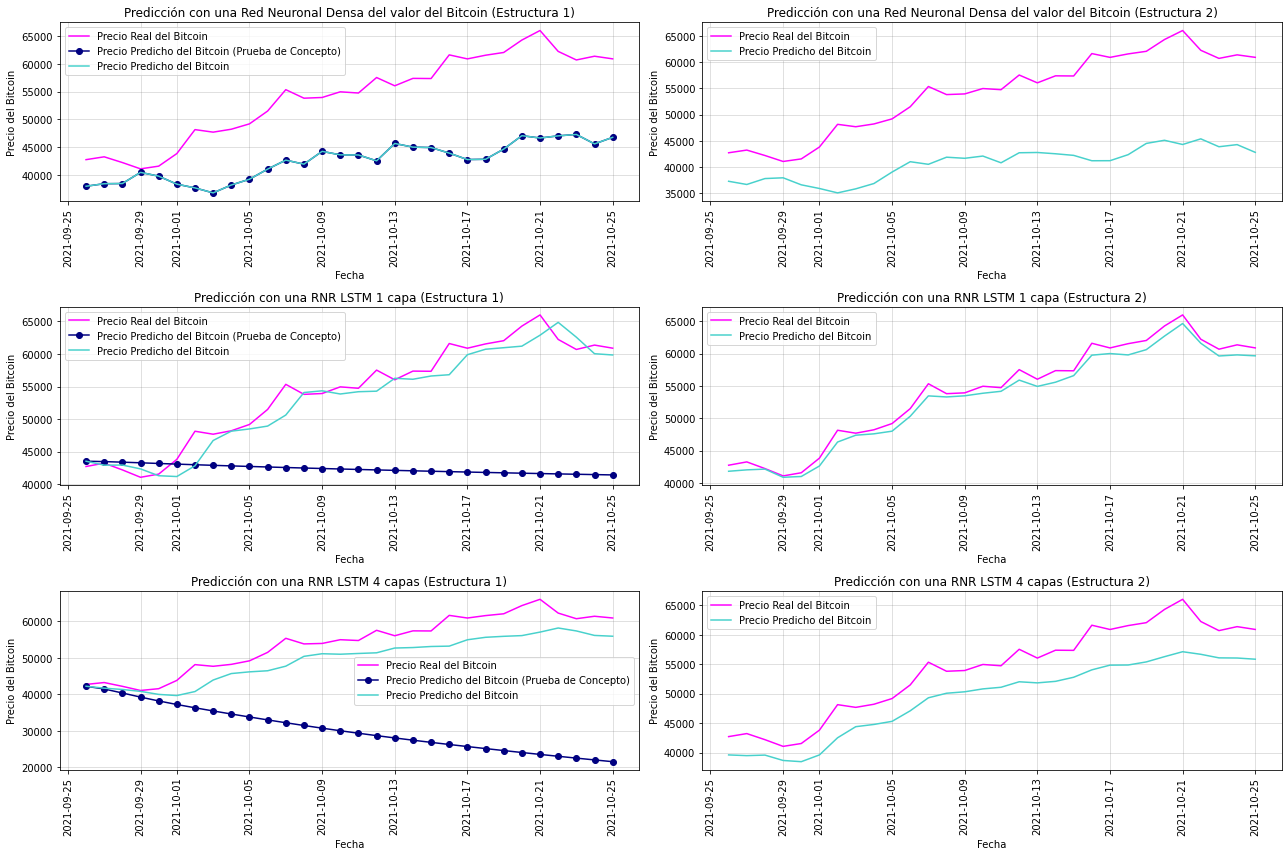

In [59]:
fig, axes = plt.subplots(3,2,figsize=(18,12))
#plt.subplots_adjust(hw)
axes = axes.flatten().T


ax = axes[0]
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1, color = 'navy',marker='o', label = 'Precio Predicho del Bitcoin (Prueba de Concepto)')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt2[0], color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una Red Neuronal Densa del valor del Bitcoin (Estructura 1)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

ax = axes[1]
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_dense_s2, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una Red Neuronal Densa del valor del Bitcoin (Estructura 2)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

ax = axes[2]
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt2_lstm1_s1[0], color = 'navy',marker='o', label = 'Precio Predicho del Bitcoin (Prueba de Concepto)')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_lstm1_s1, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una RNR LSTM 1 capa (Estructura 1)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

ax = axes[3]
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_lstm_s2, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una RNR LSTM 1 capa (Estructura 2)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

ax = axes[4]
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt2_lstm2_s1[0], color = 'navy',marker='o', label = 'Precio Predicho del Bitcoin (Prueba de Concepto)')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_lstm2_s1, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una RNR LSTM 4 capas (Estructura 1)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

ax = axes[5]
ax.grid(alpha=0.3,color='gray')
ax.plot(data_test.Date.values, test_set, color = 'magenta', label = 'Precio Real del Bitcoin')
ax.plot(data_test.Date.values, predicted_bitcoin_price_xt1_lstm2_s2, color = 'mediumturquoise', label = 'Precio Predicho del Bitcoin')
ax.set_title("Predicción con una RNR LSTM 4 capas (Estructura 2)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio del Bitcoin")
ax.tick_params(rotation=90,axis='x')
ax.legend()

fig.tight_layout()


Se calcula el **Root Mean Squared Error** para todas las iteraciones y se presentan en formato tabla:

In [60]:
df_rmse_modelos = pd.DataFrame(index=['E1','E1_PoC','E2'],columns=['Dense','LSTM_1','LSTM_4'])
df_rmse_modelos.iloc[0,0] = round(mean_squared_error(test_set,predicted_bitcoin_price_xt1)**(1/2),2)
df_rmse_modelos.iloc[1,0] = round(mean_squared_error(test_set,predicted_bitcoin_price_xt2[0])**(1/2),2)
df_rmse_modelos.iloc[2,0] = round(mean_squared_error(test_set,predicted_bitcoin_price_xt1_dense_s2)**(1/2),2)
df_rmse_modelos.iloc[0,1] = round(mean_squared_error(test_set,predicted_bitcoin_price_xt1_lstm1_s1)**(1/2),2)
df_rmse_modelos.iloc[1,1] = round(mean_squared_error(test_set,predicted_bitcoin_price_xt2_lstm1_s1[0])**(1/2),2)
df_rmse_modelos.iloc[2,1] = round(mean_squared_error(test_set,predicted_bitcoin_price_xt1_lstm_s2)**(1/2),2)
df_rmse_modelos.iloc[0,2] = round(mean_squared_error(test_set,predicted_bitcoin_price_xt1_lstm2_s1)**(1/2),2)
df_rmse_modelos.iloc[1,2] = round(mean_squared_error(test_set,predicted_bitcoin_price_xt2_lstm2_s1[0])**(1/2),2)
df_rmse_modelos.iloc[2,2] = round(mean_squared_error(test_set,predicted_bitcoin_price_xt1_lstm2_s2)**(1/2),2)

print('Resultados RMSE')
df_rmse_modelos

Resultados RMSE


,Dense,LSTM_1,LSTM_4
E1,12598.64,2167.45,4944.85
E1_PoC,12598.64,14222.52,27131.8
E2,14212.49,1195.21,5079.43


* Para la arquitectura **Dense y estructura 1** se puede apreciar que el valor predicho a pesar de estar bastante alejado del valor real, la forma de la **tendencia es muy similar**, adicionalmente, se obtienen **resultados casi idénticos** en valor predicho con la estructura en su estado original y la prueba de concepto (ver valor de RMSE). En la presente arquitectura es la que se encontró **mejor resultado en la PoC en cuanto a similaridad de tendencia con los valores reales**, por lo que se puede decir que una **red sin recurrencia podría favorecer** más al desafío planteado en dicha PoC.
* Para las redes **LSTM con estructura 1**, se tiene un **comportamiento bastante particular en el valor predicho**. Dado que la red neuronal recurrente sólo está utilizando su propia tendencia para predecir el siguiente valor, se aprecia un fenómeno de desfase en el que el valor se va ajustando a la misma forma de la tendencia pero con un **retardo de un día**, lo que en ámbitos prácticos no resultaría útil ya que el objetivo sería predecir el siguiente día. Con respecto al comportamiento de la **PoC en las arquitecturas LSTM** se puede observar un comportamiento de predicción deficiente, ya que una vez la red empieza a arrojar predicciones, se va **sesgando a los cambios causados por sus propias predicciones**, causando que dichas predicciones sigan una tendencia de línea recta. Para estos casos, son los que se tienen **peores RMSE**.
* Los valores predichos con la red **Dense y estructura 2**, tienen bastante similaridad en tendencia a los valores predichos en la misma red con la estructura 1. Aun así, el RMSE es más alto por lo que para esta arquitectura se encontró mayor acercamiento a los valores reales con la estructura 1.
* La utilización de **variables dependientes en las redes LSTM (E2)** (además del histórico de la misma variable a predecir), **mejoró considerablemente** el resultado obtenido en comparación con las redes LSTM que sólo utilizaron el histórico de la misma variable para predecir los siguientes valores. Se puede observar que la tendencia de valores predichos es **muy similar a la de valores reales y sin ningún desfase**, por lo que añadir las variables dependientes ha sido un **gran aporte al modelo de predicción**. Con la red **LSTM de una capa** se pueden observar puntos visualmente coincidentes y una separación muy estrecha entre las tendencias, además para este caso se obtiene el valor de **RMSE más bajo**. A pesar de que la red **LSTM de 4 capas** era una arquitectura de mayor complejidad, ésta obtuvo un valor de **RMSE bastante bajo, pero no tan bajo como el de LSTM_1**.

---
### 7.- CONCLUSIONES FINALES
De acuerdo a los resultados obtenidos, se puede concluir que en redes LSTM no resulta de gran utilidad predecir los valores de la serie de tiempo a partir de su mismo valor, ya que la tendencia predicha ha resultado desfasada en el mejor de los casos, por lo que el aprendizaje de sí misma tendría un retraso y los valores van adoptando la misma tendencia sólo por el hecho de que se van añadiendo los valores reales actualizados al array a predecir, por lo que un desfase de un día es similar a no ejecutar predicción válida alguna.

Es relevante mencionar la importancia de las variables dependientes en las redes LSTM, ya que han añadido mayor robustez al modelo, permitiendo eliminar el desfase de los modelos univariados, añadiéndole la utilidad buscada a las predicciones, acercándose éstas mucho más a los valores reales sin algún desfase en tiempo evidente.

En el Deep Learning, hay una inclinación por pensar en que un modelo más complejo podría arrojar mejores resultados. Sin embargo, en este caso de estudio se obtuvo mejores resultados para una RNR de sólo una capa, en comparación a una RNR de 4 capas. Adicionalmente, se obtuvo menor error en la predicción al no considerar una capa oculta densa luego de la(s) capa(s) LSTM, por lo que se tuvo que modificar la propuesta inicial, la cual añadía mayor complejidad a las arqutecturas.

En el alcance del caso de estudio, las redes neuronales densas sólo podrían servir para predecir la forma de la tendencia de los valores, ya que en sus distintas estructuras se encuentran resultados similares en la forma de la serie de tiempo con respecto al valor predicho, sin embargo, respecto a los valores numéricos obtenidos se aprecia un gran error en las predicciones.